# Classification: Initial tinkering with E. coli iModulon data to see if we can train a CNN to classify promoters into iModulons

In [49]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats


import altair as alt
import seaborn as sns
import torch_utils as tu

import torch

import random
random.seed(46)

In [2]:
import utils as u 
import torch_utils as tu
import models as m

from sklearn.metrics import r2_score

from skorch import NeuralNetRegressor,NeuralNetClassifier
from skorch.callbacks import EarlyStopping,Checkpoint,GradientNormClipping
from skorch.dataset import Dataset
from skorch.helper import predefined_split


## Load data

In [3]:
fname = 'ec_iMod_out/ecoli_seq_M_opFilt.tsv' 
XY = pd.read_csv(fname,sep='\t')
print(XY.shape)
display(XY.head())

loc2seq = dict([(x,z) for (x,z) in XY[['locus_tag','upstream_region']].values])

print(loc2seq['b3575'])

(2129, 99)


locus_tag  gene                                 product type  strand  start  \
0     b0005  yaaX  DUF2502 domain-containing protein YaaX  CDS       1   5233   
1     b0007  yaaJ               putative transporter YaaJ  CDS      -1   6528   
2     b0008  talB                         transaldolase B  CDS       1   8237   
3     b0009   mog       molybdopterin adenylyltransferase  CDS       1   9305   
4     b0010  satP        acetate/succinate:H(+) symporter  CDS      -1   9927   

                                     upstream_region         0         1  \
0  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...  0.008229 -0.000685   
1  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...  0.008111 -0.003929   
2  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...  0.008629 -0.001270   
3  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...  0.002952  0.002053   
4  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...  0.006142  0.000884   

          2  ...        82        83        84        85        86        87  \
0 -0.005215  ... -0.006856  0.010676  0.008874  0.018497  0.000700 -0.013267   
1  0.003207  ... -0.000337 -0.010468  0.016122  0.010361 -0.003899 -0.022839   
2 -0.005664  ...  0.000394  0.007215 -0.000707 -0.012959 -0.002329  0.006391   
3 -0.002882  ... -0.009291 -0.000226  0.016013  0.002179  0.004891 -0.002365   
4  0.008166  ... -0.009214 -0.010588  0.001363  0.003979 -0.005208  0.003190   

         88        89        90        91  
0  0.015265  0.016886 -0.015319 -0.020727  
1 -0.003665 -0.001823 -0.023604 -0.012765  
2 -0.003650 -0.008537  0.002898 -0.000891  
3 -0.003490 -0.006066 -0.011982  0.011477  
4 -0.015137 -0.005784 -0.001302  0.010800  

[5 rows x 99 columns]

TCAATCAGCATCAACCCGCGAAACAGACTCTGGCTTCCGGCTGGACGCTCTTTTTCCTGCGCCATCTCGTTCTCTTTTTTTCCCATCACTTCTTTCCCCATTTTGTCGCGTCCTGATGGTAGCGCAAAGTGTGCCGTAGTTCACGATCTCGACAGATAATTTATAACCAATTGATTTTTATGTCTTTTGAAATTCATCAATCAGATTGCCTTGTTAAAAAGTGATCGATATATTTGAAATCAAGTTTCGCATATTGAAATTTTAAGCCAAAAAAGCGATCAAAAAAACAAGGAAGCCTGG


In [4]:
# get iModulon column labels
M = pd.read_csv('ec_iMod_out/iMod_download/M.csv',index_col=0)
imods = [x.strip() for x in M.columns]
imods[:5]

['0', '1', '2', '3', '4']

In [5]:
# load binarized version of M matrix
Mb = pd.read_csv('ec_iMod_out/iMod_download/gene_presence_matrix.csv',index_col=0).astype(int)
Mb.index.name='locus_tag'
Mb

0  1  2  3  4  5  6  7  8  9  ...  82  83  84  85  86  87  88  89  \
locus_tag                                ...                                   
b0002      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0003      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0004      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0005      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0006      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
...       .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..   
b4688      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4693      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4696_1    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4696_2    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4705      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   

           90  91  
locus_tag          
b0002       0   0  
b0003       0   0  
b0004       0   0  
b0005       0   0  
b0006       0   0  
...        ..  ..  
b4688       0   0  
b4693       0   0  
b4696_1     0   0  
b4696_2     0   0  
b4705       0   0  

[3923 rows x 92 columns]

In [6]:
# Convert XY into binarazed version
XYb = pd.merge(XY.drop(imods,axis=1), Mb.reset_index(),on='locus_tag')
XYb

locus_tag  gene                                          product type  \
0        b0005  yaaX           DUF2502 domain-containing protein YaaX  CDS   
1        b0007  yaaJ                        putative transporter YaaJ  CDS   
2        b0008  talB                                  transaldolase B  CDS   
3        b0009   mog                molybdopterin adenylyltransferase  CDS   
4        b0010  satP                 acetate/succinate:H(+) symporter  CDS   
...        ...   ...                                              ...  ...   
2124     b4395  ytjC                             putative phosphatase  CDS   
2125     b4396   rob   DNA-binding transcriptional dual regulator Rob  CDS   
2126     b4397  creA                      PF05981 family protein CreA  CDS   
2127     b4401  arcA  DNA-binding transcriptional dual regulator ArcA  CDS   
2128     b4403  yjtD        putative tRNA/rRNA methyltransferase YjtD  CDS   

      strand    start                                    upstream_region  0  \
0          1     5233  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...  0   
1         -1     6528  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...  0   
2          1     8237  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...  0   
3          1     9305  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...  0   
4         -1     9927  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...  0   
...      ...      ...                                                ... ..   
2124       1  4633796  TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...  0   
2125      -1  4634440  ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...  0   
2126       1  4635520  CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...  0   
2127      -1  4639589  ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...  0   
2128       1  4640941  TAAATGCTAGCTTTCGTCACATTATTTTAATAATCCAACTAGTTGC...  0   

      1  2  ...  82  83  84  85  86  87  88  89  90  91  
0     0  0  ...   0   0   0   0   0   0   0   0   0   0  
1     0  0  ...   0   0   0   0   0   0   0   0   0   0  
2     0  0  ...   0   0   0   0   0   0   0   0   0   0  
3     0  0  ...   0   0   0   0   0   0   0   0   0   0  
4     0  0  ...   0   0   0   0   0   0   0   0   0   0  
...  .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2124  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2125  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2126  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2127  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2128  0  0  ...   0   0   0   0   0   0   0   0   0   0  

[2129 rows x 99 columns]

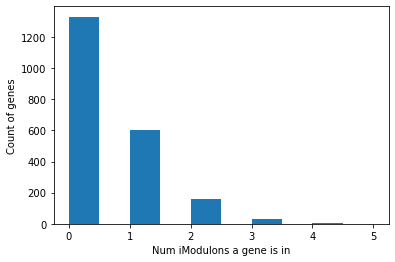

In [7]:
# distribution of ecoli genes and how many iMods they are in
plt.hist([sum(XYb.iloc[i][imods]) for i in range(XYb.shape[0])])
plt.xlabel("Num iModulons a gene is in")
plt.ylabel("Count of genes")
plt.show()

## Filter out uninformative iModulons (and genes?)
* Some iModulons have too few genes to learn from. Get rid of any less than 5. (after filtering out for genes in operons)
* Some genes aren't in any iModulons. Are those worth excluding too?

In [8]:
# make a list of imodulons above a certain threshold
thresh = 4
#mbc = dict([(Mb.iloc[i].name,sum(Mb.iloc[i])) for i in range(Mb.shape[0])])
XYim = XYb[imods]
mbc = dict([(XYim.T.iloc[i].name,sum(XYim.T.iloc[i])) for i in range(XYim.shape[1])])
imods_filt = [x for x in mbc if mbc[x]>thresh]
print("num iMods that pass:",len(imods_filt))

num iMods that pass: 58


In [9]:
# these iMods seem too small to meaningfully try to predict
# (some are single-gene iMods)
imods_exclude = [x for x in mbc if mbc[x]<=thresh]
print(f"num iMods filtered out b/c fewer than {thresh} genes: {len(imods_exclude)}")

num iMods filtered out b/c fewer than 4 genes: 34


In [10]:
# drop excluded iMods and keep binary labels
XY = XYb.drop(imods_exclude,axis=1)
XY

locus_tag  gene                                          product type  \
0        b0005  yaaX           DUF2502 domain-containing protein YaaX  CDS   
1        b0007  yaaJ                        putative transporter YaaJ  CDS   
2        b0008  talB                                  transaldolase B  CDS   
3        b0009   mog                molybdopterin adenylyltransferase  CDS   
4        b0010  satP                 acetate/succinate:H(+) symporter  CDS   
...        ...   ...                                              ...  ...   
2124     b4395  ytjC                             putative phosphatase  CDS   
2125     b4396   rob   DNA-binding transcriptional dual regulator Rob  CDS   
2126     b4397  creA                      PF05981 family protein CreA  CDS   
2127     b4401  arcA  DNA-binding transcriptional dual regulator ArcA  CDS   
2128     b4403  yjtD        putative tRNA/rRNA methyltransferase YjtD  CDS   

      strand    start                                    upstream_region  0  \
0          1     5233  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...  0   
1         -1     6528  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...  0   
2          1     8237  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...  0   
3          1     9305  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...  0   
4         -1     9927  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...  0   
...      ...      ...                                                ... ..   
2124       1  4633796  TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...  0   
2125      -1  4634440  ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...  0   
2126       1  4635520  CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...  0   
2127      -1  4639589  ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...  0   
2128       1  4640941  TAAATGCTAGCTTTCGTCACATTATTTTAATAATCCAACTAGTTGC...  0   

      1  2  ...  76  77  78  79  80  82  83  84  86  88  
0     0  0  ...   0   0   0   0   0   0   0   0   0   0  
1     0  0  ...   0   0   0   0   0   0   0   0   0   0  
2     0  0  ...   0   0   0   0   0   0   0   0   0   0  
3     0  0  ...   0   0   0   0   0   0   0   0   0   0  
4     0  0  ...   0   0   0   0   0   0   0   0   0   0  
...  .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2124  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2125  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2126  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2127  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2128  0  0  ...   0   0   0   0   0   0   0   0   0   0  

[2129 rows x 65 columns]

## splitting

In [50]:
# Split data into train/test/split here and now
full_train_df,test_df = tu.quick_split(XY)
train_df, val_df = tu.quick_split(full_train_df)

print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)


# # coi1 = ['0','1','2','3','4']
# # coi2 = ['5','6','7','8','9']
# # coi3 = ['10','11','12','13','14']
# coi1 = imods_filt[:10]
# assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])
# view_train_test_dist(train_df, test_df,coi1,"M-matrix weights",val_df=val_df)
# # view_train_test_dist(train_df, test_df,coi2,"M-matrix weights",val_df=val_df)
# # view_train_test_dist(train_df, test_df,coi3,"M-matrix weights",val_df=val_df)

# view_train_test_dist(full_train_df, test_df,coi1,"M-matrix weights")


(1703, 66)
(426, 66)
(1362, 67)
(341, 67)


## convert to skorch-able dfs

In [51]:
def make_mt_skorch_dfs(df,seq_col='seq',target_cols=['highCu','noCu']):
    '''
    Make multi-task X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    # number of labels = len(target_cols)
    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [52]:
X, y = make_mt_skorch_dfs(XY, seq_col="upstream_region",target_cols=imods_filt)
print("\nX:",X.shape)
print("y:",y.shape)

Xtrain, ytrain = make_mt_skorch_dfs(train_df, seq_col="upstream_region",target_cols=imods_filt)
print("\nXtrain:",Xtrain.shape)
print("ytrain:",ytrain.shape)

Xval, yval = make_mt_skorch_dfs(val_df, seq_col="upstream_region",target_cols=imods_filt)
print("\nXval:",Xval.shape)
print("yval:",yval.shape)

Xtest, ytest = make_mt_skorch_dfs(test_df, seq_col="upstream_region",target_cols=imods_filt)
print("\nXtest:",Xtest.shape)
print("ytest:",ytest.shape)

Xfull_train, yfull_train = make_mt_skorch_dfs(full_train_df, seq_col="upstream_region",target_cols=imods_filt)
print("\nXfull_train:",Xfull_train.shape)
print("yfull_train:",yfull_train.shape)


X: torch.Size([2129, 300, 4])
y: torch.Size([2129, 58])

Xtrain: torch.Size([1362, 300, 4])
ytrain: torch.Size([1362, 58])

Xval: torch.Size([341, 300, 4])
yval: torch.Size([341, 58])

Xtest: torch.Size([426, 300, 4])
ytest: torch.Size([426, 58])

Xfull_train: torch.Size([1703, 300, 4])
yfull_train: torch.Size([1703, 58])


In [53]:
def count_imod_train_test_labels(imods,ytr,yte):
    '''
    Given a train and test set of y labels, count how many trues
    are in each imodulon for each split
    '''
    # loop through each train example and count True labels for each imodulon
    imc_train = torch.tensor([0 for x in range(ytr.shape[1])])
    for s in ytr:
        imc_train += s.long()

    # loop through each test example and count True labels for each imodulon
    imc_test = torch.tensor([0 for x in range(yte.shape[1])])
    for s in yte:
        imc_test += s.long()
    
    # print warning for missing examples
    for i,im in enumerate(imods):
        if imc_train[i] == 0:
            print(f"WARNING: iMod {im} train set missing True example.")
        if imc_test[i] == 0:
            print(f"WARNING: iMod {im} test set missing True example.")
            
    # make sure the len of these imod vectors is the same
    assert len(imc_train) == len(imc_test) == len(imods)

    # stack into a pandas df, melt it, plot it
    ts = np.array(torch.stack((torch.tensor([int(x) for x in imods]), imc_train, imc_test)).T)
    imc_df = pd.DataFrame(data=ts,columns=['imod','train_count','test_count'])
    imc_df_melt = imc_df.melt(id_vars=['imod'],value_vars=['train_count','test_count'],var_name='split',value_name='count')
    
    # plot stuff
    plt.figure(figsize=(20,5))
    sns.barplot(data=imc_df_melt, x='imod', y='count', hue='split')
    #plt.yscale('log')
    
    #return imc_df_melt

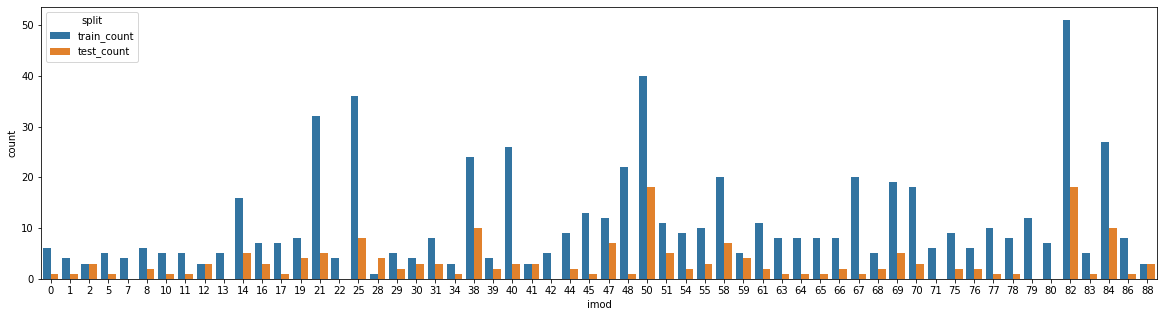

In [54]:
count_imod_train_test_labels(imods_filt,ytrain,ytest)

### try splitting with sci-kit multilearn to stratify classes?

In [55]:
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

In [56]:
print("\nX:",X.shape)
print("y:",y.shape)


X: torch.Size([2129, 300, 4])
y: torch.Size([2129, 58])


In [57]:
Xtrain_strat, ytrain_strat, Xtest_strat, ytest_strat = iterative_train_test_split(X, y, test_size = 0.2)


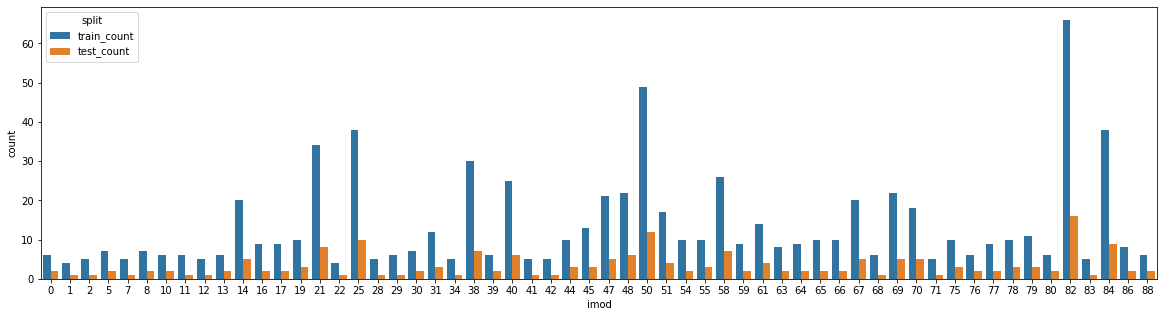

In [58]:
count_imod_train_test_labels(imods_filt,ytrain_strat,ytest_strat)

Note: The stratified split doesn't having any iMods missing true examples!

In [20]:
# make skorch predefined valid ds
# valid_ds = Dataset(Xval, yval)

## pick some params

In [21]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [22]:
from skorch import NeuralNet
import torch.nn as nn
from skorch.dataset import ValidSplit

In [63]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification

net_randsplit = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(),
    train_split=ValidSplit(0.2),
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.01,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [64]:
net_randsplit.fit(Xfull_train, yfull_train)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6134       0.6334        0.4888  0.1213
      2        0.2494       0.6334        0.0516  0.1183
      3        0.0529       0.6334        0.0683  0.0867
      4        0.0646       0.6334        0.0641  0.0859
      5        0.0539       0.6334        0.0518  0.0784
      6        0.0464       0.6334        0.0485  0.0774
      7        0.0448       0.6334        0.0470  0.0773
      8        0.0440       0.6334        0.0465  0.0775
      9        0.0438       0.6334        0.0463  0.0772
     10        0.0437       0.6334        0.0462  0.0776
     11        0.0437       0.6334        0.0461  0.0771
     12        0.0437       0.6334        0.0461  0.0771
     13        0.0437       0.6334        0.0461  0.0770
     14        0.0437       0.6334        0.0461  0.0771
     15        0.0437       0.6334        0.0461  0.0777
     16        0.0437       0.6

    139        0.0438       0.6334        0.0460  0.0778
    140        0.0438       0.6334        0.0461  0.0778
    141        0.0438       0.6334        0.0460  0.0777
    142        0.0438       0.6334        0.0461  0.0773
    143        0.0438       0.6334        0.0461  0.0775
    144        0.0438       0.6334        0.0461  0.0782
    145        0.0438       0.6334        0.0461  0.0781
    146        0.0438       0.6334        0.0461  0.0780
    147        0.0438       0.6334        0.0460  0.0778
    148        0.0438       0.6334        0.0461  0.0777
    149        0.0438       0.6334        0.0460  0.0777
    150        0.0438       0.6334        0.0461  0.0784
    151        0.0438       0.6334        0.0461  0.0784
    152        0.0438       0.6334        0.0461  0.0783
    153        0.0438       0.6334        0.0460  0.0780
    154        0.0438       0.6334        0.0460  0.0779
    155        0.0438       0.6334        0.0460  0.0777
    156        0.0439       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=58, bias=True)
    )
  ),
)

In [41]:
pr = net_randsplit.predict(Xtest)
pr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Viz model results

In [42]:
def sk_loss_plot(nets,yscaler=5):
    '''
    Draw the train/val losses from a skorch net
    '''
    
    fig = plt.figure(figsize=(10,5))
    smallest_val = 999
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=1.0,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')
        
        if val_min < smallest_val:
            smallest_val = val_min

    plt.ylim(0,smallest_val*yscaler)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    

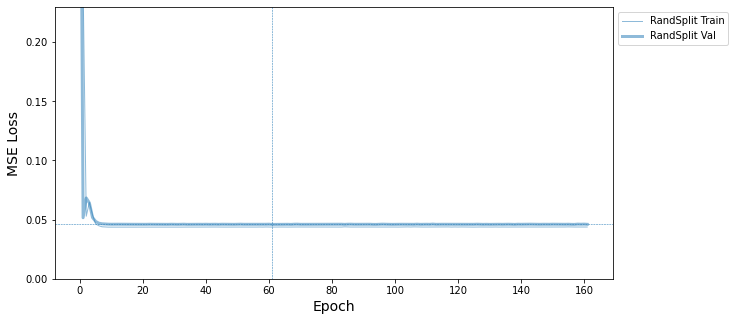

In [65]:
nets = [
    (net_randsplit,'RandSplit'),
]

sk_loss_plot(nets)

In [28]:
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay

In [29]:
#def plot_confusion_multi(models,genes,oracle,objs):
def plot_confusion_multi(models,Xs,ys,imods):
    '''Get class predictions and plot confusion matrix'''

    for sk_model,model_name in models:
        #model.eval()
        print(f"Running {model_name}")
        
        y_preds = sk_model.predict(Xs)
        
        confs = multilabel_confusion_matrix(ys, y_preds)

        # display the matrix
        #for i in range(y_preds.shape[1]):
        for i,imod in enumerate(imods):
            mats = []
            c = confs[i]
            mats.append((c,f"raw counts"))
            # get the normalized confusino matrix
            cp = np.zeros(c.shape)
            for i,row in enumerate(c):
                rowsum = sum(row)
                for j,item in enumerate(row):
                    val = item/rowsum
                    cp[i][j] = val

            mats.append((cp,f"normed counts"))
            #print(mats)
            
            f, axes = plt.subplots(1, 2, figsize=(5, 3))#, sharey='row')
            axes = list(axes)
            #axes_list = [item for sublist in axes for item in sublist]
            
            for i,(mat,title) in enumerate(mats):
                disp = ConfusionMatrixDisplay(confusion_matrix=mat)
                #disp.plot(ax=axes_list.pop(0))
                disp.plot(ax=axes.pop(0))
                disp.ax_.set_title(title)
            
            f.suptitle(f"{model_name}, iMod {imod}",fontsize=20)
            #plt.title(f"{model_name}, iMod {imod}")
            plt.tight_layout()
            # plt.show()
        
#    return dfs


Running RandSplit


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


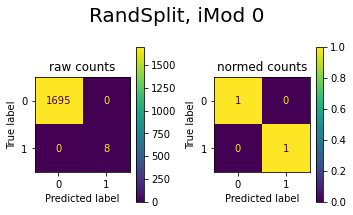

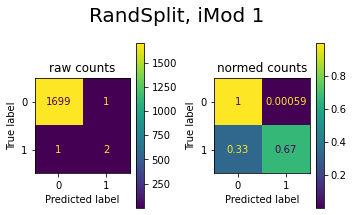

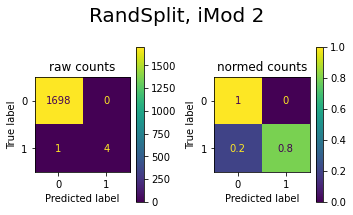

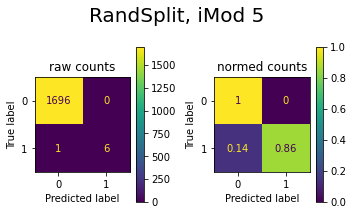

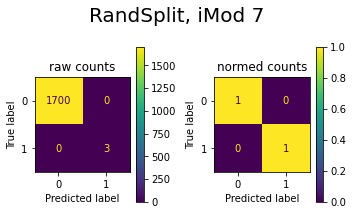

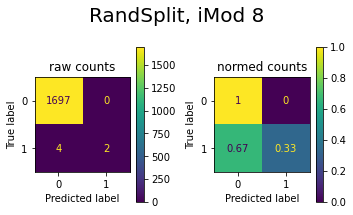

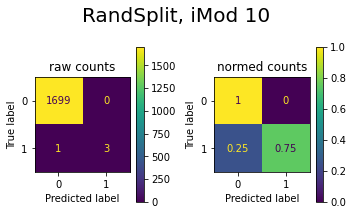

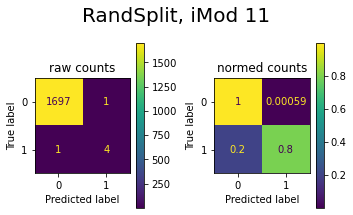

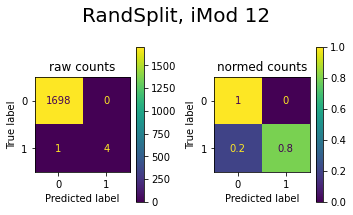

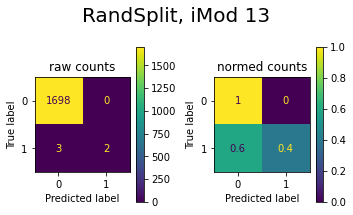

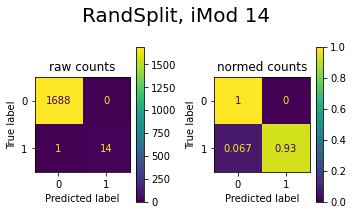

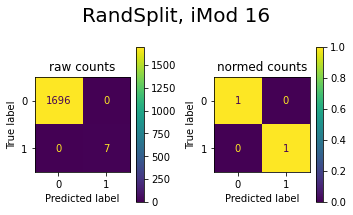

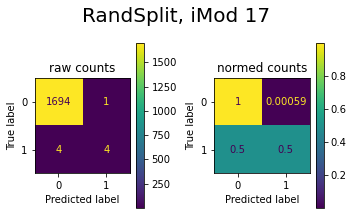

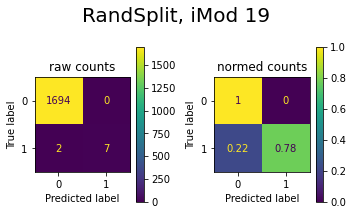

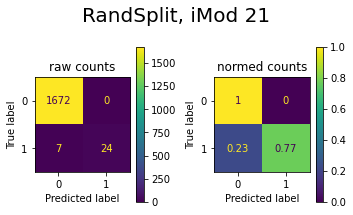

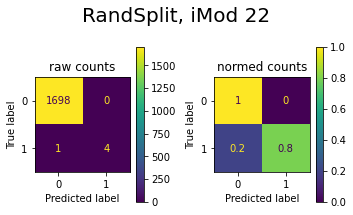

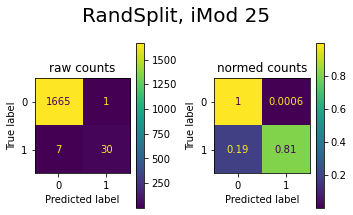

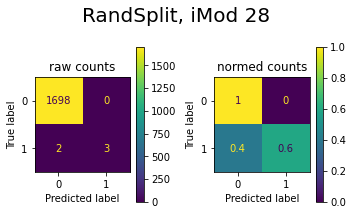

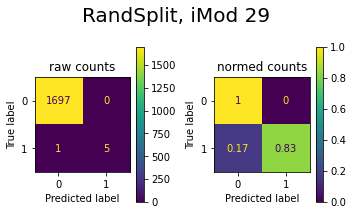

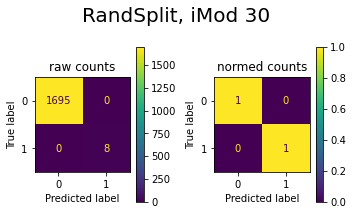

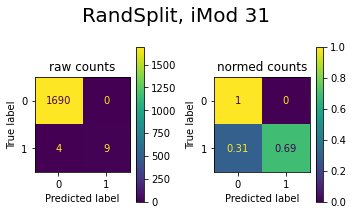

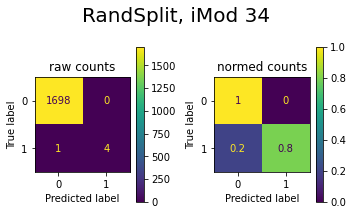

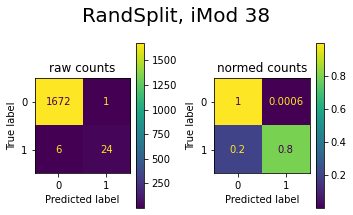

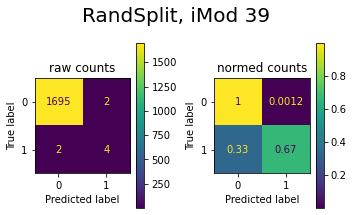

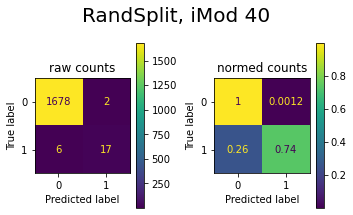

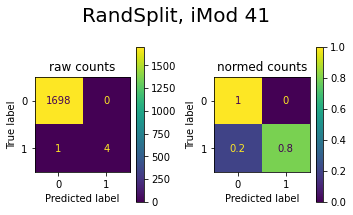

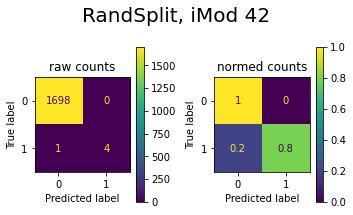

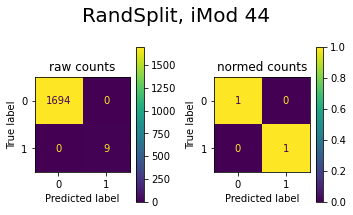

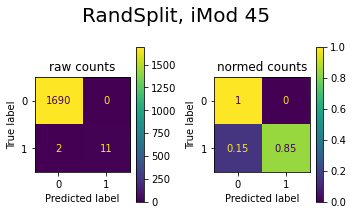

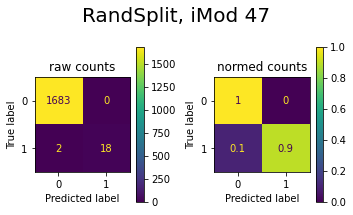

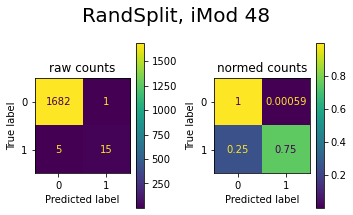

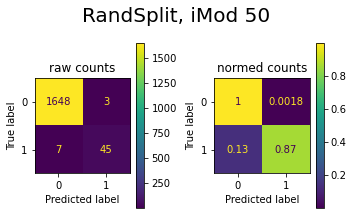

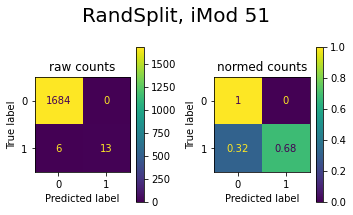

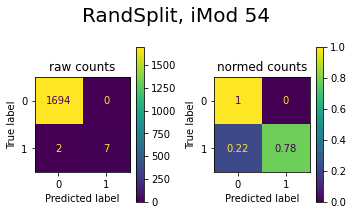

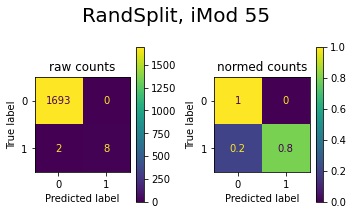

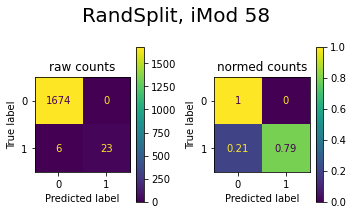

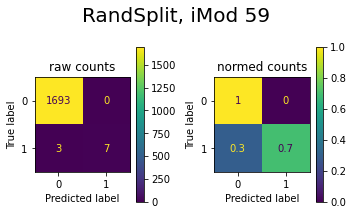

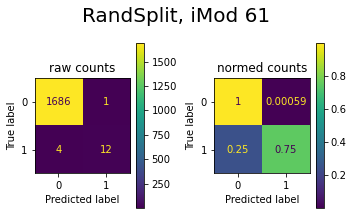

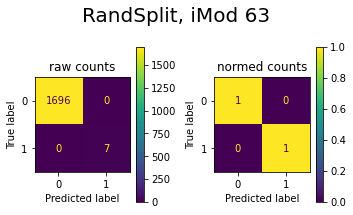

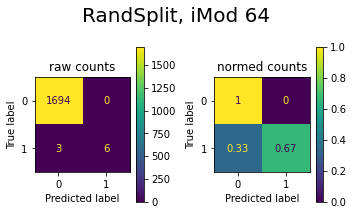

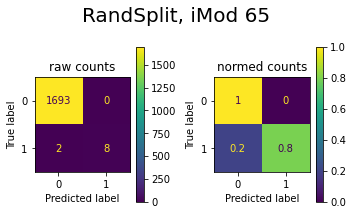

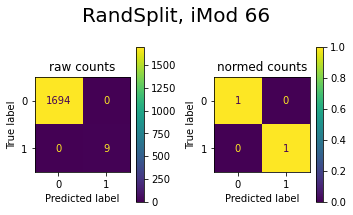

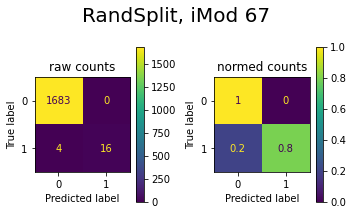

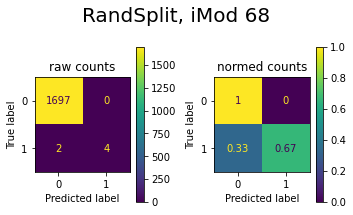

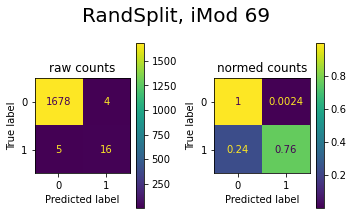

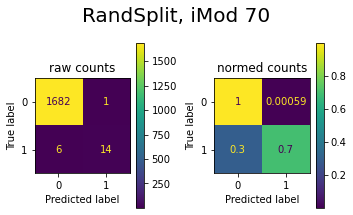

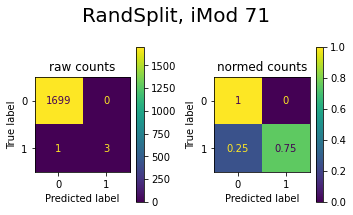

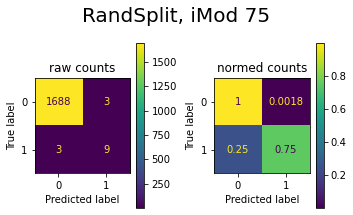

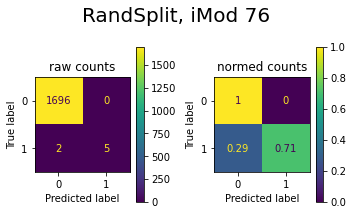

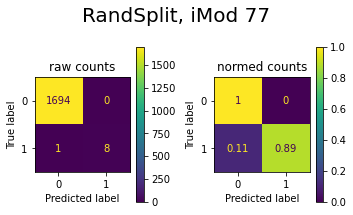

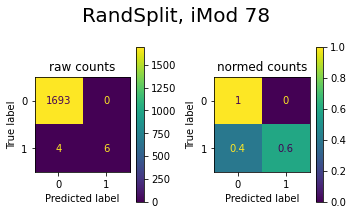

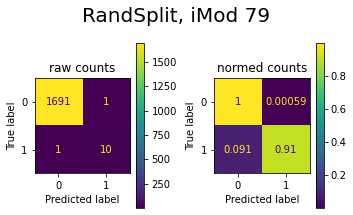

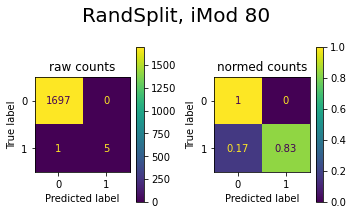

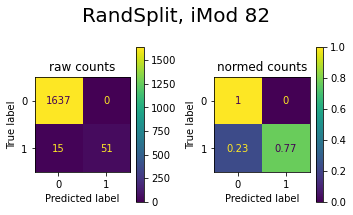

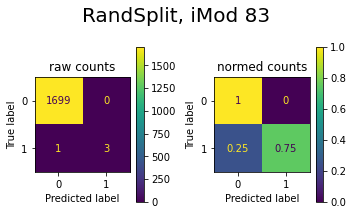

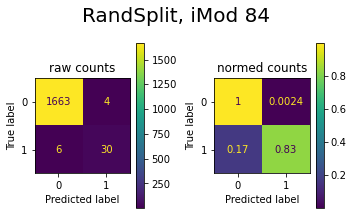

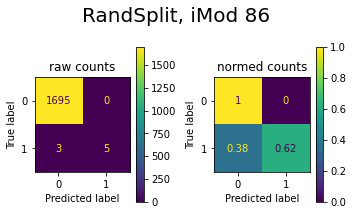

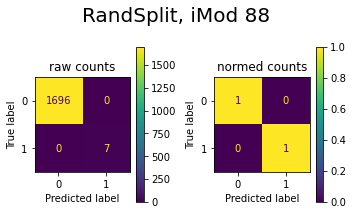

In [30]:
plot_confusion_multi(nets, Xfull_train,yfull_train,imods_filt)

Running RandSplit


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


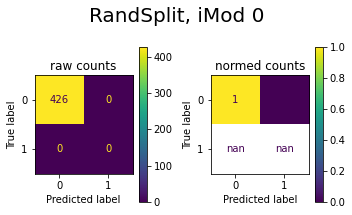

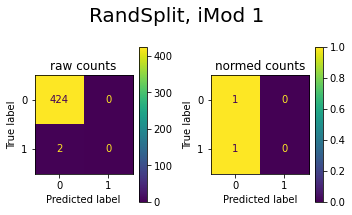

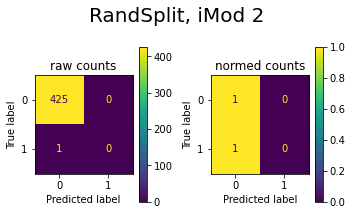

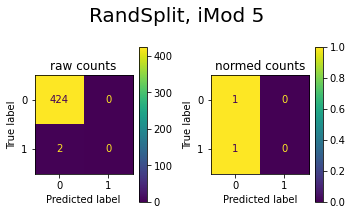

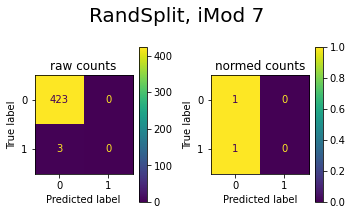

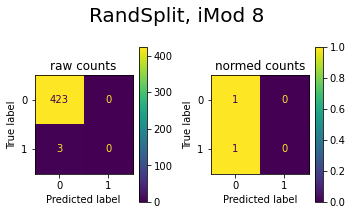

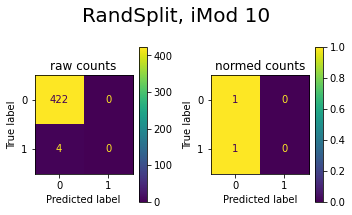

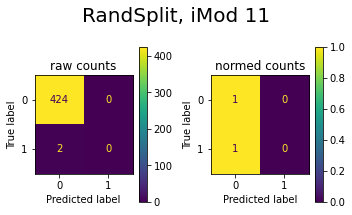

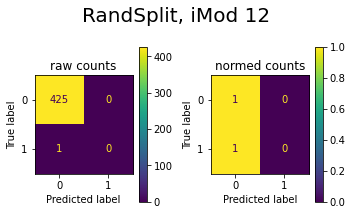

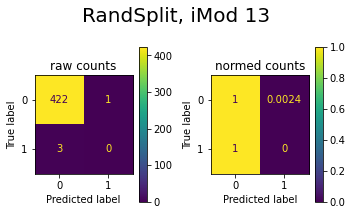

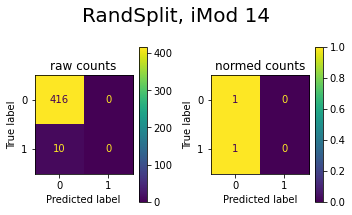

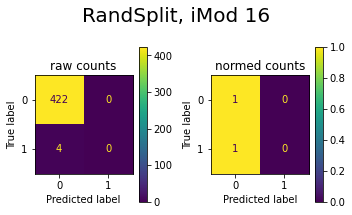

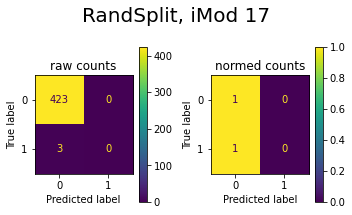

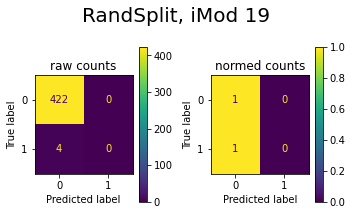

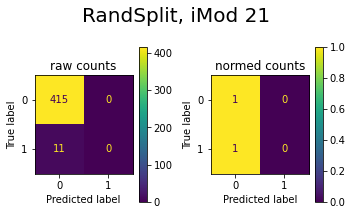

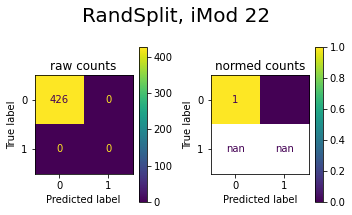

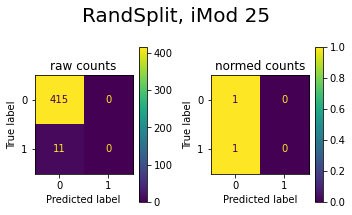

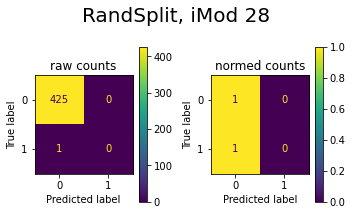

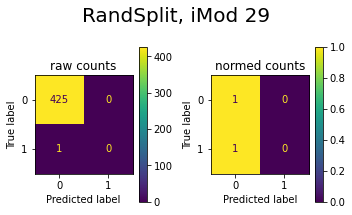

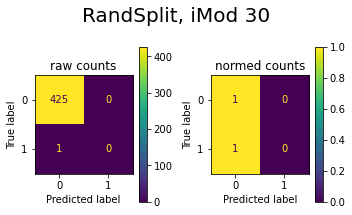

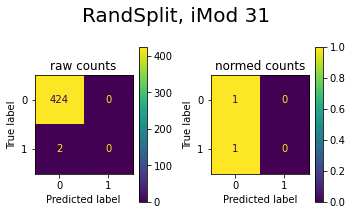

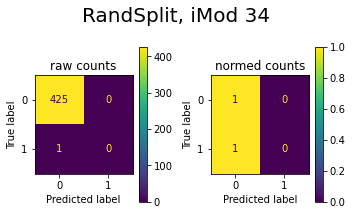

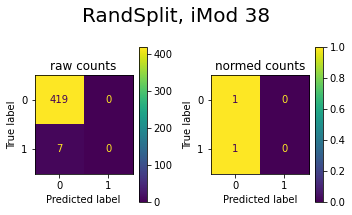

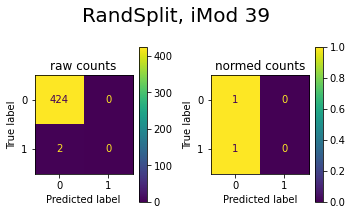

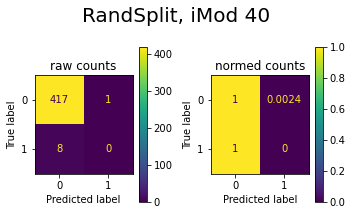

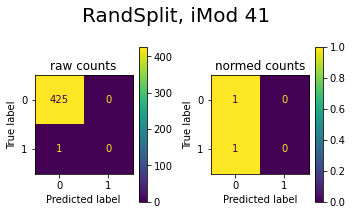

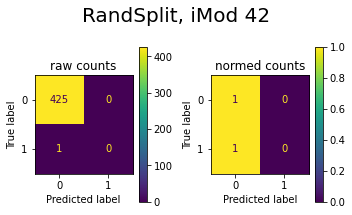

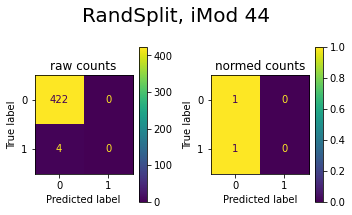

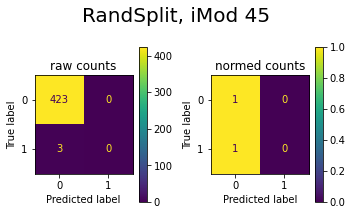

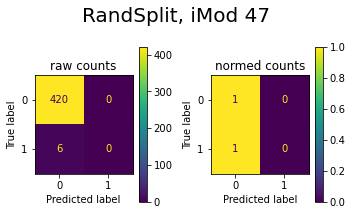

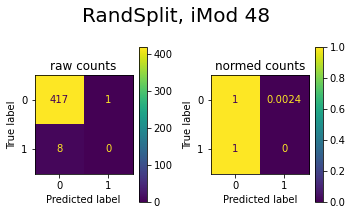

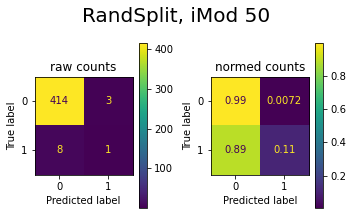

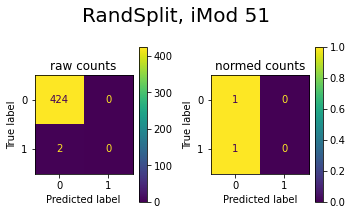

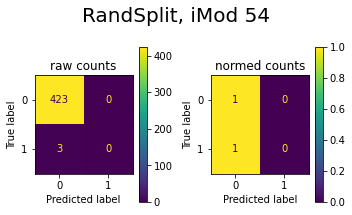

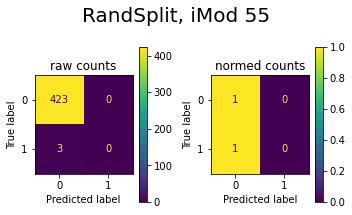

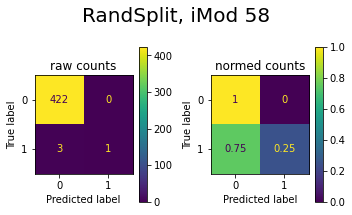

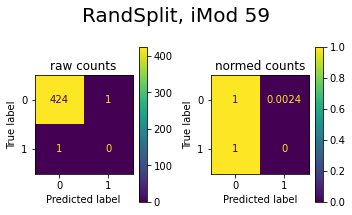

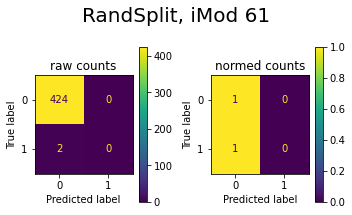

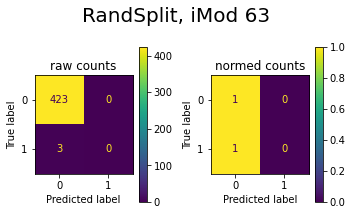

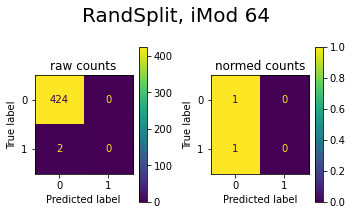

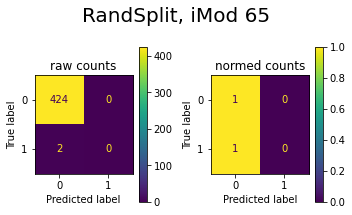

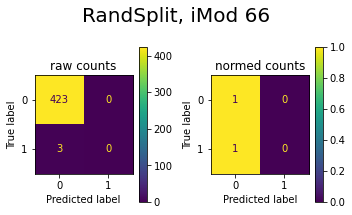

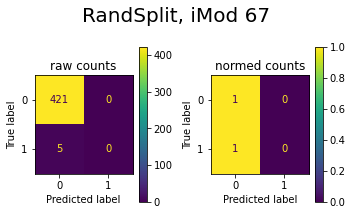

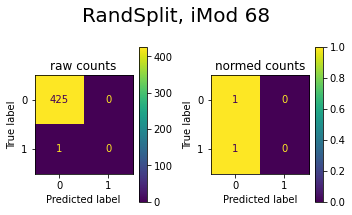

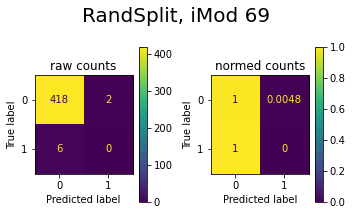

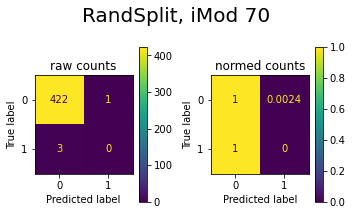

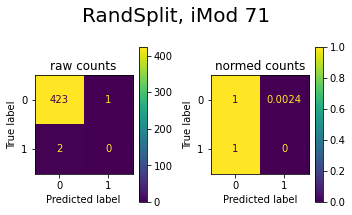

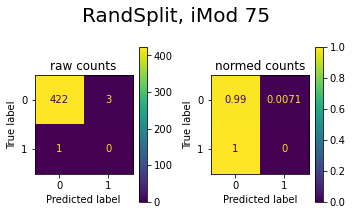

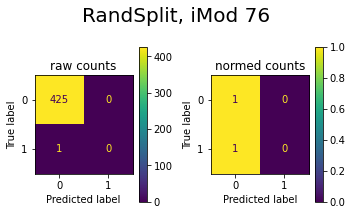

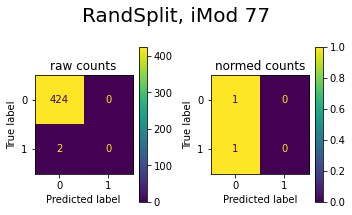

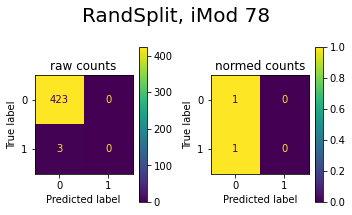

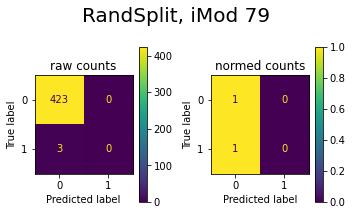

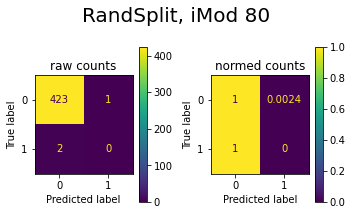

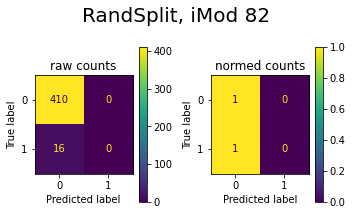

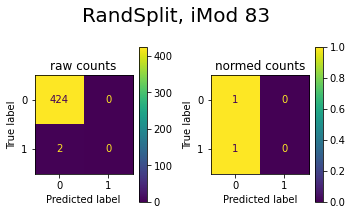

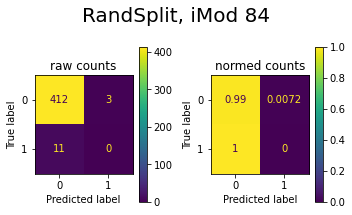

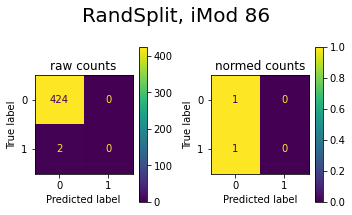

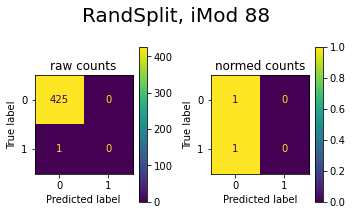

In [31]:
plot_confusion_multi(nets, Xtest,ytest,imods_filt)

In [32]:
from sklearn.metrics import classification_report

In [33]:
def alt_cls_summary(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color='score:Q',
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_circle().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        size='support:Q',
        tooltip=['support']
    ).properties(width=600)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def alt_cls_summary2(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color='score:Q',
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_bar().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        y='support:Q',
        tooltip=['support']
    ).properties(width=600,height=50)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def view_cls_report(sk_model,Xs,ys,imods):
    '''
    For a given model and set of X,y examples, save and display 
    a summary of the primary classification metrics
    '''
    # get the predictions and classification report
    y_preds = sk_model.predict(Xs)
    cls_rep = classification_report(ys, y_preds,target_names=imods,output_dict=True)
    
    # conver the dict into a df for viewing
    cls_df = pd.DataFrame.from_dict(cls_rep,orient='index')
    cls_df.index.name='imod'
    cls_df = cls_df.reset_index()
    
    # drop the micro/macro average colums
    cls_df = cls_df.drop(cls_df[~cls_df['imod'].isin(imods)].index)
    # convert to int for sorting
    cls_df['imod'] = cls_df['imod'].apply(lambda x: int(x))
    
    # melt the df for altair
    cls_melt = cls_df.melt(
        id_vars=['imod','support'],
        value_vars=['precision','recall','f1-score'],
        var_name='metric',
        value_name='score')
    
    #alt_cls_summary(cls_melt)
    display(alt_cls_summary2(cls_melt))

    return cls_df
    
    
    

In [66]:
cls_full_train_df = view_cls_report(net_randsplit,Xfull_train,yfull_train,imods_filt)
cls_test_df = view_cls_report(net_randsplit,Xtest,ytest,imods_filt)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

alt.VConcatChart(...)

## train classifier with stratsplit

In [112]:
net_stratsplit = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(),
    train_split=ValidSplit(0.2,stratified=True),
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.01,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [113]:
net_stratsplit.fit(Xtrain_strat, ytrain_strat)
## Hm, maybe think about switching this to cross_val_predict?
# Is skorch just using 1 val split and sometimes getting lucky?

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

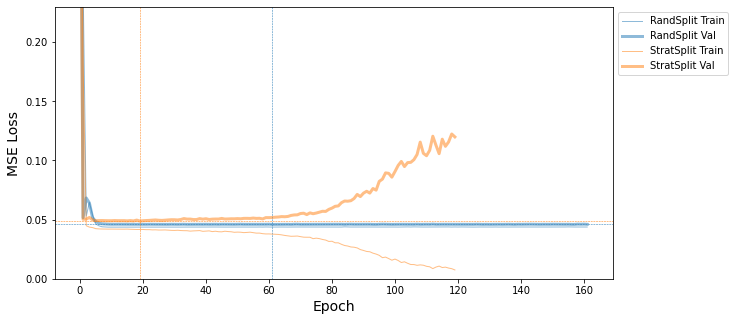

In [88]:
nets = [
    (net_randsplit,'RandSplit'),
    (net_stratsplit,'StratSplit'),
]

sk_loss_plot(nets)

In [89]:
cls_full_train_df = view_cls_report(net_stratsplit,Xtrain_strat,ytrain_strat,imods_filt)
cls_test_df = view_cls_report(net_stratsplit,Xtest_strat,ytest_strat,imods_filt)

alt.VConcatChart(...)

alt.VConcatChart(...)

# What's up with this overfitting vs not overfitting thing?

In [92]:
# run a bunch of loops?
nets = []
for i in range(20):
    net = NeuralNetClassifier(
        m.DNA_2CNN_2FC_Multi, # my pytorch model
        criterion=torch.nn.BCEWithLogitsLoss(),
        train_split=ValidSplit(0.2),
        module__seq_len=300, # pass arg to pytorch model
        module__n_tasks=ytrain.shape[1],
        module__num_filters1=128,
        module__num_filters2=64,
        module__kernel_size1=8,
        module__kernel_size2=8,
        module__conv_pool_size1=3, 
        module__conv_pool_size2=1,
        module__fc_node_num1 = 100,
        module__fc_node_num2 = 100,
        module__dropout1 = 0.2,
        module__dropout2 = 0.2,
        max_epochs=2000,
        lr=0.01,
        device=DEVICE,
         callbacks=[
             EarlyStopping(patience=500),
             #Checkpoint(load_best=True),
             GradientNormClipping()
         ],
        optimizer=torch.optim.Adam,
        iterator_train__shuffle=True,
        #train_split=predefined_split(valid_ds)
        #train_split=None
    )
    
    net.fit(Xtrain_strat, ytrain_strat)
    
    nets.append((net,f"StratSplit Net {i}"))
    

#sk_loss_plot(nets)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3254       0.6422        0.1533  0.1228
      2        0.0729       0.6422        0.0551  0.1110
      3        0.0507       0.6422        0.0518  0.1050
      4        0.0451       0.6422        0.0481  0.0843
      5        0.0437       0.6422        0.0470  0.0835
      6        0.0431       0.6422        0.0477  0.0786
      7        0.0430       0.6422        0.0482  0.0778
      8        0.0426       0.6422        0.0482  0.0778
      9        0.0430       0.6422        0.0486  0.0778
     10        0.0432       0.6422        0.0472  0.0781
     11        0.0427       0.6422        0.0471  0.0783
     12        0.0425       0.6422        0.0477  0.0773
     13        0.0427       0.6422        0.0479  0.0779
     14        0.0426       0.6422        0.0470  0.0772
     15        0.0425       0.6422        0.0473  0.0778
     16        0.0426       0.6

    131        0.0044       0.6012        0.1536  0.0785
    132        0.0038       0.6129        0.1592  0.0782
    133        0.0041       0.5836        0.1580  0.0784
    134        0.0039       0.6246        0.1737  0.0783
    135        0.0049       0.6217        0.1658  0.0784
    136        0.0051       0.5865        0.1321  0.0783
    137        0.0042       0.5894        0.1535  0.0784
    138        0.0038       0.6070        0.1563  0.0784
    139        0.0037       0.5924        0.1586  0.0784
    140        0.0027       0.6188        0.1658  0.0782
    141        0.0033       0.6217        0.1699  0.0783
    142        0.0028       0.6129        0.1620  0.0786
    143        0.0031       0.6041        0.1626  0.0786
    144        0.0030       0.6070        0.1715  0.0784
    145        0.0028       0.6188        0.1769  0.0784
    146        0.0033       0.5924        0.1665  0.0784
    147        0.0034       0.5953        0.1557  0.0784
    148        0.0036       0.6

    274        0.0040       0.5660        0.2158  0.0783
    275        0.0049       0.6012        0.2342  0.0782
    276        0.0034       0.6129        0.2314  0.0785
    277        0.0035       0.6100        0.2292  0.0790
    278        0.0046       0.6070        0.2461  0.0784
    279        0.0045       0.6158        0.2093  0.0783
    280        0.0043       0.6188        0.2132  0.0781
    281        0.0029       0.6129        0.2198  0.0781
    282        0.0036       0.5953        0.2143  0.0785
    283        0.0030       0.6188        0.2242  0.0784
    284        0.0038       0.6129        0.2221  0.0782
    285        0.0026       0.6100        0.2563  0.0784
    286        0.0030       0.5953        0.2192  0.0783
    287        0.0021       0.6305        0.2226  0.0776
    288        0.0020       0.6158        0.2184  0.0776
    289        0.0018       0.6158        0.2426  0.0775
    290        0.0025       0.6188        0.2570  0.0774
    291        0.0022       0.5

    418        0.0042       0.6100        0.3251  0.0786
    419        0.0034       0.6070        0.3123  0.0786
    420        0.0030       0.6217        0.3197  0.0784
    421        0.0041       0.5982        0.3101  0.0786
    422        0.0029       0.6158        0.3402  0.0788
    423        0.0041       0.6070        0.3237  0.0786
    424        0.0040       0.6100        0.3653  0.0787
    425        0.0046       0.6100        0.3416  0.0785
    426        0.0045       0.5806        0.3261  0.0782
    427        0.0058       0.6100        0.4061  0.0788
    428        0.0068       0.5924        0.3422  0.0795
    429        0.0049       0.6158        0.3636  0.0790
    430        0.0052       0.5924        0.3222  0.0787
    431        0.0040       0.6217        0.3456  0.0789
    432        0.0035       0.6070        0.3301  0.0789
    433        0.0043       0.6158        0.3321  0.0785
    434        0.0050       0.6012        0.3127  0.0787
    435        0.0053       0.5

     30        0.0430       0.6921        0.0376  0.0779
     31        0.0426       0.6921        0.0374  0.0781
     32        0.0421       0.6921        0.0383  0.0782
     33        0.0418       0.6921        0.0383  0.0781
     34        0.0414       0.6921        0.0377  0.0781
     35        0.0415       0.6921        0.0381  0.0782
     36        0.0412       0.6921        0.0383  0.0780
     37        0.0412       0.6921        0.0387  0.0784
     38        0.0413       0.6921        0.0382  0.0782
     39        0.0409       0.6921        0.0386  0.0781
     40        0.0399       0.6921        0.0381  0.0782
     41        0.0396       0.6921        0.0387  0.0783
     42        0.0395       0.6921        0.0390  0.0783
     43        0.0394       0.6921        0.0386  0.0781
     44        0.0389       0.6921        0.0408  0.0782
     45        0.0384       0.6921        0.0388  0.0787
     46        0.0371       0.6921        0.0404  0.0785
     47        0.0363       0.6

    164        0.0041       0.6246        0.1221  0.0777
    165        0.0050       0.6334        0.1194  0.0776
    166        0.0050       0.6481        0.1074  0.0775
    167        0.0053       0.6100        0.0997  0.0777
    168        0.0051       0.6452        0.1118  0.0780
    169        0.0039       0.6422        0.1158  0.0778
    170        0.0036       0.6334        0.1126  0.0776
    171        0.0048       0.6364        0.1104  0.0780
    172        0.0041       0.6393        0.1161  0.0780
    173        0.0043       0.6129        0.1111  0.0776
    174        0.0041       0.6188        0.1179  0.0778
    175        0.0037       0.6452        0.1219  0.0782
    176        0.0041       0.6598        0.1223  0.0779
    177        0.0038       0.6422        0.1182  0.0778
    178        0.0041       0.6393        0.1129  0.0777
    179        0.0031       0.6452        0.1137  0.0777
    180        0.0035       0.6364        0.1191  0.0776
    181        0.0033       0.6

    307        0.0041       0.6188        0.1606  0.0781
    308        0.0053       0.6012        0.1356  0.0783
    309        0.0053       0.6628        0.1595  0.0782
    310        0.0054       0.6334        0.1442  0.0781
    311        0.0044       0.6334        0.1422  0.0782
    312        0.0044       0.6393        0.1443  0.0785
    313        0.0036       0.6158        0.1401  0.0782
    314        0.0033       0.6452        0.1427  0.0779
    315        0.0033       0.6305        0.1414  0.0786
    316        0.0031       0.6452        0.1419  0.0789
    317        0.0039       0.6540        0.1472  0.0789
    318        0.0044       0.6393        0.1437  0.0786
    319        0.0031       0.6598        0.1589  0.0784
    320        0.0025       0.6334        0.1488  0.0782
    321        0.0032       0.6393        0.1544  0.0783
    322        0.0038       0.6217        0.1419  0.0782
    323        0.0045       0.6540        0.1481  0.0783
    324        0.0050       0.6

    451        0.0065       0.6217        0.1670  0.0781
    452        0.0065       0.5982        0.1518  0.0784
    453        0.0072       0.6276        0.1621  0.0783
    454        0.0065       0.6452        0.1566  0.0782
    455        0.0056       0.6276        0.1633  0.0779
    456        0.0057       0.6452        0.1552  0.0780
    457        0.0065       0.6334        0.1583  0.0787
    458        0.0059       0.6041        0.1658  0.0781
    459        0.0055       0.6246        0.1664  0.0780
    460        0.0049       0.6452        0.1725  0.0778
    461        0.0046       0.6393        0.1550  0.0780
    462        0.0049       0.6686        0.1640  0.0781
    463        0.0040       0.6364        0.1584  0.0784
    464        0.0041       0.6393        0.1694  0.0783
    465        0.0033       0.6510        0.1754  0.0784
    466        0.0037       0.6452        0.1850  0.0781
    467        0.0040       0.6481        0.1943  0.0784
    468        0.0034       0.6

     69        0.0430       0.6510        0.0454  0.0776
     70        0.0430       0.6510        0.0455  0.0775
     71        0.0430       0.6510        0.0455  0.0778
     72        0.0430       0.6510        0.0455  0.0775
     73        0.0431       0.6510        0.0454  0.0778
     74        0.0430       0.6510        0.0455  0.0780
     75        0.0431       0.6510        0.0455  0.0774
     76        0.0431       0.6510        0.0454  0.0776
     77        0.0431       0.6510        0.0455  0.0778
     78        0.0431       0.6510        0.0454  0.0777
     79        0.0430       0.6510        0.0455  0.0778
     80        0.0431       0.6510        0.0455  0.0778
     81        0.0431       0.6510        0.0457  0.0775
     82        0.0431       0.6510        0.0454  0.0780
     83        0.0431       0.6510        0.0455  0.0776
     84        0.0431       0.6510        0.0455  0.0775
     85        0.0431       0.6510        0.0453  0.0775
     86        0.0431       0.6

    213        0.0431       0.6510        0.0457  0.0777
    214        0.0431       0.6510        0.0454  0.0778
    215        0.0431       0.6510        0.0454  0.0778
    216        0.0431       0.6510        0.0455  0.0777
    217        0.0430       0.6510        0.0454  0.0776
    218        0.0431       0.6510        0.0455  0.0777
    219        0.0432       0.6510        0.0457  0.0778
    220        0.0431       0.6510        0.0453  0.0777
    221        0.0430       0.6510        0.0454  0.0777
    222        0.0430       0.6510        0.0457  0.0781
    223        0.0431       0.6510        0.0454  0.0775
    224        0.0431       0.6510        0.0455  0.0779
    225        0.0431       0.6510        0.0455  0.0778
    226        0.0431       0.6510        0.0454  0.1619
    227        0.0431       0.6510        0.0456  0.0784
    228        0.0431       0.6510        0.0454  0.0780
    229        0.0431       0.6510        0.0455  0.0777
    230        0.0431       0.6

    357        0.0431       0.6510        0.0454  0.0777
    358        0.0431       0.6510        0.0455  0.0777
    359        0.0431       0.6510        0.0456  0.0778
    360        0.0431       0.6510        0.0454  0.0781
    361        0.0431       0.6510        0.0454  0.0780
    362        0.0430       0.6510        0.0456  0.0780
    363        0.0431       0.6510        0.0454  0.0779
    364        0.0430       0.6510        0.0455  0.0781
    365        0.0431       0.6510        0.0457  0.0784
    366        0.0432       0.6510        0.0455  0.0783
    367        0.0431       0.6510        0.0454  0.0778
    368        0.0431       0.6510        0.0456  0.0780
    369        0.0431       0.6510        0.0456  0.0780
    370        0.0431       0.6510        0.0453  0.0782
    371        0.0431       0.6510        0.0454  0.0784
    372        0.0431       0.6510        0.0457  0.0781
    373        0.0431       0.6510        0.0454  0.0779
    374        0.0431       0.6

    501        0.0431       0.6510        0.0456  0.0777
    502        0.0431       0.6510        0.0455  0.0778
    503        0.0430       0.6510        0.0454  0.0777
    504        0.0430       0.6510        0.0454  0.0779
    505        0.0430       0.6510        0.0455  0.0777
    506        0.0430       0.6510        0.0454  0.0788
    507        0.0430       0.6510        0.0454  0.0786
    508        0.0430       0.6510        0.0455  0.0787
    509        0.0430       0.6510        0.0455  0.0785
    510        0.0430       0.6510        0.0454  0.0788
    511        0.0430       0.6510        0.0454  0.0788
    512        0.0430       0.6510        0.0454  0.0785
    513        0.0430       0.6510        0.0456  0.0788
    514        0.0430       0.6510        0.0455  0.0783
    515        0.0430       0.6510        0.0455  0.0776
    516        0.0430       0.6510        0.0455  0.0780
    517        0.0430       0.6510        0.0453  0.0778
    518        0.0430       0.6

    645        0.0430       0.6510        0.0454  0.0783
    646        0.0430       0.6510        0.0454  0.0782
    647        0.0430       0.6510        0.0455  0.0791
    648        0.0430       0.6510        0.0454  0.0782
    649        0.0430       0.6510        0.0454  0.0783
    650        0.0430       0.6510        0.0454  0.0784
    651        0.0430       0.6510        0.0454  0.0787
    652        0.0430       0.6510        0.0455  0.0792
    653        0.0430       0.6510        0.0455  0.0784
    654        0.0430       0.6510        0.0455  0.0786
    655        0.0430       0.6510        0.0455  0.0781
    656        0.0430       0.6510        0.0454  0.0784
    657        0.0430       0.6510        0.0454  0.0783
    658        0.0430       0.6510        0.0455  0.0789
    659        0.0430       0.6510        0.0454  0.0782
    660        0.0430       0.6510        0.0454  0.0782
    661        0.0430       0.6510        0.0455  0.0782
    662        0.0430       0.6

    789        0.0431       0.6510        0.0455  0.0786
    790        0.0430       0.6510        0.0454  0.0793
    791        0.0430       0.6510        0.0454  0.0791
    792        0.0430       0.6510        0.0454  0.0786
    793        0.0430       0.6510        0.0454  0.0791
    794        0.0430       0.6510        0.0456  0.0788
Stopping since valid_loss has not improved in the last 500 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3632       0.6305        0.1509  0.0780
      2        0.0698       0.6305        0.0595  0.0783
      3        0.0487       0.6305        0.0502  0.0776
      4        0.0444       0.6305        0.0497  0.0785
      5        0.0436       0.6305        0.0492  0.0781
      6        0.0428       0.6305        0.0487  0.0781
      7        0.0422       0.6305        0.0491  0.0779
      8        0.0423       0.6305        0.0497  0.0780
      9        0.0421

    122        0.0056       0.6012        0.1385  0.0782
    123        0.0054       0.6012        0.1612  0.0785
    124        0.0061       0.5953        0.1523  0.0780
    125        0.0064       0.5924        0.1470  0.0782
    126        0.0060       0.5924        0.1393  0.0781
    127        0.0060       0.5924        0.1405  0.0779
    128        0.0054       0.5924        0.1545  0.0780
    129        0.0058       0.5865        0.1479  0.0781
    130        0.0066       0.5894        0.1493  0.0781
    131        0.0055       0.5689        0.1484  0.0782
    132        0.0051       0.5836        0.1676  0.0779
    133        0.0050       0.5718        0.1748  0.0781
    134        0.0060       0.5425        0.1609  0.0779
    135        0.0062       0.5894        0.1652  0.0784
    136        0.0062       0.5865        0.1510  0.0784
    137        0.0053       0.6012        0.1497  0.0781
    138        0.0049       0.6100        0.1761  0.0780
    139        0.0045       0.6

    264        0.0041       0.5982        0.2220  0.0779
    265        0.0036       0.5777        0.2607  0.0783
    266        0.0056       0.5836        0.2461  0.0784
    267        0.0046       0.5718        0.2395  0.0783
    268        0.0049       0.5865        0.2514  0.0782
    269        0.0045       0.5718        0.2553  0.0782
    270        0.0048       0.5806        0.2555  0.0781
    271        0.0045       0.5953        0.2526  0.0784
    272        0.0051       0.5865        0.2572  0.0785
    273        0.0044       0.5777        0.2202  0.0783
    274        0.0043       0.5748        0.2493  0.0784
    275        0.0038       0.5806        0.2456  0.0782
    276        0.0037       0.5982        0.2328  0.0782
    277        0.0041       0.6188        0.2511  0.0781
    278        0.0037       0.6158        0.2675  0.0780
    279        0.0039       0.5513        0.2190  0.0781
    280        0.0037       0.5748        0.2299  0.0781
    281        0.0038       0.5

    408        0.0071       0.5718        0.2773  0.0787
    409        0.0053       0.5982        0.2943  0.0784
    410        0.0048       0.6041        0.2731  0.0790
    411        0.0040       0.5894        0.2654  0.0792
    412        0.0048       0.5982        0.3081  0.0788
    413        0.0043       0.6070        0.2898  0.0790
    414        0.0038       0.5836        0.2820  0.0789
    415        0.0043       0.5894        0.3038  0.0786
    416        0.0028       0.5953        0.3171  0.0784
    417        0.0040       0.5982        0.3234  0.0788
    418        0.0047       0.5953        0.3144  0.0787
    419        0.0062       0.5718        0.2644  0.0787
    420        0.0043       0.5982        0.2809  0.0788
    421        0.0045       0.5689        0.2815  0.0783
    422        0.0043       0.5865        0.2917  0.0785
    423        0.0039       0.5924        0.3116  0.0789
    424        0.0061       0.5924        0.3155  0.0787
    425        0.0049       0.6

     40        0.0429       0.6686        0.0432  0.0780
     41        0.0431       0.6686        0.0422  0.0779
     42        0.0423       0.6686        0.0423  0.0775
     43        0.0425       0.6686        0.0426  0.0776
     44        0.0420       0.6686        0.0427  0.0775
     45        0.0418       0.6686        0.0428  0.0776
     46        0.0416       0.6686        0.0429  0.0776
     47        0.0412       0.6686        0.0433  0.0779
     48        0.0413       0.6686        0.0444  0.0783
     49        0.0415       0.6686        0.0457  0.0785
     50        0.0416       0.6686        0.0430  0.0781
     51        0.0410       0.6686        0.0448  0.0783
     52        0.0402       0.6686        0.0441  0.0785
     53        0.0399       0.6686        0.0445  0.0784
     54        0.0396       0.6686        0.0443  0.0792
     55        0.0399       0.6686        0.0468  0.0785
     56        0.0392       0.6686        0.0451  0.0781
     57        0.0384       0.6

    174        0.0043       0.6070        0.1672  0.0779
    175        0.0043       0.6041        0.2017  0.0783
    176        0.0036       0.6188        0.2022  0.0781
    177        0.0037       0.6188        0.2252  0.0780
    178        0.0043       0.6041        0.1908  0.0779
    179        0.0040       0.6070        0.1926  0.0784
    180        0.0044       0.6188        0.2004  0.0786
    181        0.0044       0.6158        0.1887  0.0783
    182        0.0054       0.5806        0.2209  0.0784
    183        0.0054       0.6188        0.1952  0.0782
    184        0.0056       0.5982        0.1909  0.0790
    185        0.0050       0.5894        0.1953  0.0795
    186        0.0042       0.6012        0.1979  0.0784
    187        0.0039       0.6188        0.1935  0.0789
    188        0.0037       0.6246        0.1919  0.0788
    189        0.0034       0.6276        0.1918  0.0782
    190        0.0038       0.6158        0.1879  0.0788
    191        0.0041       0.6

    318        0.0047       0.6012        0.2461  0.0778
    319        0.0047       0.6188        0.2707  0.0779
    320        0.0049       0.6100        0.2472  0.0781
    321        0.0048       0.6070        0.2707  0.0779
    322        0.0043       0.6217        0.2664  0.0781
    323        0.0039       0.5748        0.2293  0.0778
    324        0.0049       0.6041        0.2329  0.0779
    325        0.0044       0.5806        0.2357  0.0779
    326        0.0051       0.6041        0.2379  0.0782
    327        0.0053       0.5953        0.2279  0.0780
    328        0.0044       0.5806        0.2446  0.0783
    329        0.0040       0.5894        0.2213  0.0784
    330        0.0049       0.6041        0.2394  0.0781
    331        0.0041       0.6246        0.2458  0.0779
    332        0.0040       0.6158        0.2486  0.0783
    333        0.0036       0.6422        0.2396  0.0783
    334        0.0041       0.6246        0.2195  0.0786
    335        0.0041       0.6

    462        0.0055       0.6070        0.2658  0.0783
    463        0.0050       0.6158        0.2484  0.0783
    464        0.0051       0.5953        0.2590  0.0779
    465        0.0046       0.6129        0.2810  0.0782
    466        0.0047       0.6217        0.2823  0.0781
    467        0.0053       0.5982        0.2695  0.0781
    468        0.0054       0.6129        0.2833  0.0780
    469        0.0056       0.6158        0.2862  0.0780
    470        0.0045       0.6217        0.2693  0.0779
    471        0.0048       0.6158        0.2617  0.0779
    472        0.0059       0.5894        0.2371  0.0786
    473        0.0038       0.6070        0.2506  0.0786
    474        0.0041       0.6276        0.2804  0.0784
    475        0.0042       0.6158        0.2635  0.0786
    476        0.0045       0.6217        0.2675  0.0788
    477        0.0039       0.6158        0.2618  0.0787
    478        0.0043       0.6217        0.2651  0.0782
    479        0.0054       0.6

     77        0.0364       0.6393        0.0550  0.0772
     78        0.0360       0.6393        0.0549  0.0773
     79        0.0361       0.6393        0.0535  0.0774
     80        0.0357       0.6393        0.0512  0.0773
     81        0.0362       0.6364        0.0528  0.0774
     82        0.0357       0.6393        0.0537  0.0776
     83        0.0350       0.6393        0.0540  0.0776
     84        0.0346       0.6364        0.0534  0.0776
     85        0.0344       0.6393        0.0533  0.0775
     86        0.0345       0.6334        0.0529  0.0774
     87        0.0341       0.6393        0.0553  0.0774
     88        0.0333       0.6305        0.0552  0.0772
     89        0.0329       0.6393        0.0557  0.0775
     90        0.0325       0.6334        0.0563  0.0773
     91        0.0325       0.6334        0.0552  0.0773
     92        0.0323       0.6334        0.0575  0.0774
     93        0.0320       0.6334        0.0546  0.0774
     94        0.0315       0.6

    212        0.0034       0.6041        0.1539  0.0779
    213        0.0041       0.5982        0.1630  0.0777
    214        0.0036       0.5748        0.1585  0.0775
    215        0.0045       0.5982        0.1375  0.0774
    216        0.0049       0.5894        0.1401  0.0779
    217        0.0041       0.5953        0.1473  0.0783
    218        0.0037       0.6100        0.1626  0.0777
    219        0.0028       0.6070        0.1447  0.0778
    220        0.0035       0.6012        0.1575  0.0777
    221        0.0034       0.5982        0.1574  0.0775
    222        0.0035       0.5953        0.1476  0.0780
    223        0.0030       0.6188        0.1435  0.0781
    224        0.0021       0.6012        0.1698  0.0780
    225        0.0022       0.6070        0.1673  0.0782
    226        0.0032       0.5894        0.1661  0.0776
    227        0.0023       0.6188        0.1891  0.0778
    228        0.0035       0.5601        0.1631  0.0779
    229        0.0031       0.6

    356        0.0026       0.5953        0.2343  0.0785
    357        0.0033       0.5748        0.2155  0.0784
    358        0.0053       0.6100        0.2249  0.0782
    359        0.0062       0.5660        0.1713  0.0786
    360        0.0041       0.5249        0.1875  0.0784
    361        0.0038       0.6129        0.1939  0.0784
    362        0.0040       0.5894        0.1563  0.0788
    363        0.0041       0.5953        0.1566  0.0791
    364        0.0031       0.5953        0.1626  0.0785
    365        0.0042       0.5953        0.1592  0.0783
    366        0.0038       0.5660        0.1578  0.0784
    367        0.0040       0.5982        0.1801  0.0781
    368        0.0032       0.5982        0.1811  0.0781
    369        0.0025       0.5630        0.1821  0.0786
    370        0.0034       0.5836        0.1875  0.0781
    371        0.0041       0.5806        0.1876  0.0781
    372        0.0053       0.5924        0.1912  0.0783
    373        0.0052       0.5

    500        0.0037       0.5982        0.2091  0.0778
    501        0.0030       0.5630        0.2008  0.0779
    502        0.0037       0.5982        0.1881  0.0783
    503        0.0033       0.5836        0.1767  0.0784
    504        0.0050       0.5806        0.1833  0.0779
    505        0.0033       0.5894        0.1974  0.0777
    506        0.0026       0.6012        0.2238  0.0779
    507        0.0019       0.5806        0.2237  0.0780
    508        0.0031       0.5601        0.2074  0.0777
    509        0.0039       0.6041        0.2228  0.0779
    510        0.0029       0.6070        0.2255  0.0778
    511        0.0033       0.5894        0.2239  0.0778
    512        0.0043       0.5806        0.2125  0.0780
    513        0.0044       0.5689        0.2151  0.0782
    514        0.0052       0.5718        0.2220  0.0782
    515        0.0038       0.5689        0.2057  0.0783
Stopping since valid_loss has not improved in the last 500 epochs.
  epoch    train_loss

    114        0.0053       0.6657        0.1117  0.0780
    115        0.0053       0.6422        0.1108  0.0778
    116        0.0053       0.6364        0.1154  0.0776
    117        0.0055       0.6716        0.1271  0.0777
    118        0.0054       0.6393        0.1149  0.0781
    119        0.0048       0.6481        0.1108  0.0784
    120        0.0042       0.6422        0.1170  0.0782
    121        0.0039       0.6422        0.1244  0.0790
    122        0.0042       0.6481        0.1311  0.0782
    123        0.0058       0.6334        0.1189  0.0779
    124        0.0046       0.6334        0.1241  0.0781
    125        0.0048       0.6657        0.1251  0.0778
    126        0.0054       0.6510        0.1176  0.0779
    127        0.0046       0.6334        0.1136  0.0779
    128        0.0037       0.6540        0.1257  0.0777
    129        0.0053       0.6598        0.1176  0.0790
    130        0.0048       0.6452        0.1185  0.0787
    131        0.0041       0.6

    256        0.0037       0.6716        0.1705  0.0787
    257        0.0028       0.6686        0.1720  0.0781
    258        0.0028       0.6745        0.1667  0.0780
    259        0.0031       0.6364        0.1590  0.0780
    260        0.0040       0.6745        0.1918  0.0780
    261        0.0037       0.6510        0.1674  0.0780
    262        0.0033       0.6716        0.1851  0.0781
    263        0.0034       0.6452        0.1718  0.0782
    264        0.0044       0.6510        0.1666  0.0779
    265        0.0039       0.6804        0.1833  0.0778
    266        0.0039       0.6305        0.1619  0.0784
    267        0.0029       0.6510        0.1913  0.0778
    268        0.0036       0.6452        0.1695  0.0783
    269        0.0034       0.6598        0.1673  0.0781
    270        0.0037       0.6774        0.1761  0.0783
    271        0.0041       0.6657        0.1763  0.0789
    272        0.0032       0.6686        0.1906  0.0785
    273        0.0043       0.6

    400        0.0045       0.6569        0.2468  0.0783
    401        0.0045       0.6598        0.2431  0.0785
    402        0.0041       0.6657        0.2479  0.0783
    403        0.0039       0.6305        0.2269  0.0782
    404        0.0054       0.6657        0.2366  0.0781
    405        0.0041       0.6628        0.2061  0.0782
    406        0.0037       0.6774        0.2154  0.0785
    407        0.0038       0.6540        0.2044  0.0777
    408        0.0034       0.6540        0.2184  0.0781
    409        0.0041       0.6598        0.2256  0.0790
    410        0.0044       0.6657        0.2272  0.0787
    411        0.0033       0.6569        0.2231  0.0791
    412        0.0034       0.6716        0.2183  0.0790
    413        0.0034       0.6628        0.2062  0.0790
    414        0.0022       0.6657        0.2184  0.0792
    415        0.0035       0.6481        0.2220  0.0790
    416        0.0027       0.6422        0.2015  0.0788
    417        0.0043       0.6

     17        0.0434       0.6657        0.0438  0.0786
     18        0.0434       0.6657        0.0438  0.0785
     19        0.0434       0.6657        0.0437  0.0783
     20        0.0434       0.6657        0.0437  0.0780
     21        0.0434       0.6657        0.0438  0.0779
     22        0.0434       0.6657        0.0438  0.0780
     23        0.0434       0.6657        0.0437  0.0785
     24        0.0434       0.6657        0.0438  0.0784
     25        0.0434       0.6657        0.0438  0.0782
     26        0.0434       0.6657        0.0438  0.0783
     27        0.0435       0.6657        0.0437  0.0787
     28        0.0435       0.6657        0.0437  0.0784
     29        0.0435       0.6657        0.0438  0.0786
     30        0.0435       0.6657        0.0439  0.0786
     31        0.0435       0.6657        0.0438  0.0788
     32        0.0434       0.6657        0.0437  0.0779
     33        0.0435       0.6657        0.0437  0.0782
     34        0.0435       0.6

    161        0.0435       0.6657        0.0438  0.0783
    162        0.0435       0.6657        0.0439  0.0785
    163        0.0435       0.6657        0.0438  0.0794
    164        0.0435       0.6657        0.0437  0.0784
    165        0.0435       0.6657        0.0437  0.0782
    166        0.0435       0.6657        0.0437  0.0786
    167        0.0436       0.6657        0.0437  0.0785
    168        0.0436       0.6657        0.0438  0.0787
    169        0.0435       0.6657        0.0438  0.0785
    170        0.0435       0.6657        0.0439  0.0786
    171        0.0435       0.6657        0.0438  0.0783
    172        0.0436       0.6657        0.0437  0.0781
    173        0.0435       0.6657        0.0439  0.0785
    174        0.0435       0.6657        0.0438  0.0787
    175        0.0435       0.6657        0.0438  0.0786
    176        0.0435       0.6657        0.0438  0.0786
    177        0.0435       0.6657        0.0437  0.0791
    178        0.0436       0.6

    305        0.0436       0.6657        0.0436  0.0778
    306        0.0437       0.6657        0.0440  0.0783
    307        0.0437       0.6657        0.0438  0.0782
    308        0.0436       0.6657        0.0440  0.0780
    309        0.0435       0.6657        0.0438  0.0782
    310        0.0434       0.6657        0.0440  0.0779
    311        0.0437       0.6657        0.0439  0.0780
    312        0.0435       0.6657        0.0439  0.0779
    313        0.0437       0.6657        0.0438  0.0781
    314        0.0436       0.6657        0.0438  0.0781
    315        0.0435       0.6657        0.0438  0.0785
    316        0.0435       0.6657        0.0440  0.0786
    317        0.0436       0.6657        0.0437  0.0787
    318        0.0435       0.6657        0.0441  0.0782
    319        0.0435       0.6657        0.0438  0.0781
    320        0.0436       0.6657        0.0437  0.0784
    321        0.0436       0.6657        0.0438  0.0781
    322        0.0436       0.6

    449        0.0435       0.6657        0.0437  0.0785
    450        0.0436       0.6657        0.0438  0.0784
    451        0.0435       0.6657        0.0439  0.0786
    452        0.0435       0.6657        0.0439  0.0788
    453        0.0435       0.6657        0.0436  0.0784
    454        0.0434       0.6657        0.0437  0.0780
    455        0.0435       0.6657        0.0439  0.0778
    456        0.0435       0.6657        0.0439  0.0777
    457        0.0435       0.6657        0.0437  0.0782
    458        0.0435       0.6657        0.0437  0.0781
    459        0.0435       0.6657        0.0439  0.0782
    460        0.0435       0.6657        0.0438  0.0782
    461        0.0435       0.6657        0.0438  0.0786
    462        0.0435       0.6657        0.0439  0.0788
    463        0.0435       0.6657        0.0438  0.0785
    464        0.0435       0.6657        0.0438  0.0784
    465        0.0435       0.6657        0.0438  0.0779
    466        0.0435       0.6

    593        0.0435       0.6657        0.0438  0.0777
    594        0.0435       0.6657        0.0439  0.0777
    595        0.0435       0.6657        0.0438  0.0777
    596        0.0435       0.6657        0.0439  0.0777
    597        0.0435       0.6657        0.0437  0.0775
    598        0.0435       0.6657        0.0437  0.0776
    599        0.0435       0.6657        0.0437  0.0776
    600        0.0435       0.6657        0.0438  0.0777
    601        0.0435       0.6657        0.0439  0.0775
    602        0.0435       0.6657        0.0437  0.0776
    603        0.0435       0.6657        0.0437  0.0778
    604        0.0434       0.6657        0.0438  0.0787
    605        0.0435       0.6657        0.0437  0.0790
    606        0.0435       0.6657        0.0437  0.0784
Stopping since valid_loss has not improved in the last 500 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6163

    123        0.0430       0.6393        0.0459  0.0785
    124        0.0430       0.6393        0.0459  0.0783
    125        0.0430       0.6393        0.0459  0.0775
    126        0.0430       0.6393        0.0459  0.0775
    127        0.0430       0.6393        0.0459  0.0778
    128        0.0430       0.6393        0.0458  0.0774
    129        0.0430       0.6393        0.0458  0.0773
    130        0.0430       0.6393        0.0461  0.0776
    131        0.0431       0.6393        0.0459  0.0774
    132        0.0431       0.6393        0.0459  0.0774
    133        0.0431       0.6393        0.0459  0.0774
    134        0.0430       0.6393        0.0460  0.0779
    135        0.0430       0.6393        0.0458  0.0775
    136        0.0430       0.6393        0.0459  0.0774
    137        0.0430       0.6393        0.0459  0.0777
    138        0.0430       0.6393        0.0459  0.0777
    139        0.0430       0.6393        0.0459  0.0775
    140        0.0430       0.6

    267        0.0430       0.6393        0.0460  0.0781
    268        0.0432       0.6393        0.0460  0.0781
    269        0.0431       0.6393        0.0460  0.0780
    270        0.0430       0.6393        0.0457  0.0780
    271        0.0430       0.6393        0.0458  0.0781
    272        0.0430       0.6393        0.0460  0.0781
    273        0.0430       0.6393        0.0460  0.0781
    274        0.0430       0.6393        0.0460  0.0780
    275        0.0430       0.6393        0.0459  0.0781
    276        0.0430       0.6393        0.0456  0.0779
    277        0.0430       0.6393        0.0461  0.0781
    278        0.0430       0.6393        0.0458  0.0782
    279        0.0430       0.6393        0.0461  0.0781
    280        0.0429       0.6393        0.0459  0.0782
    281        0.0430       0.6393        0.0459  0.0781
    282        0.0430       0.6393        0.0459  0.0780
    283        0.0430       0.6393        0.0459  0.0781
    284        0.0430       0.6

    411        0.0430       0.6393        0.0459  0.0784
    412        0.0431       0.6393        0.0459  0.0792
    413        0.0430       0.6393        0.0459  0.0787
    414        0.0430       0.6393        0.0461  0.0783
    415        0.0429       0.6393        0.0459  0.0781
    416        0.0430       0.6393        0.0458  0.0782
    417        0.0430       0.6393        0.0459  0.0776
    418        0.0430       0.6393        0.0458  0.0780
    419        0.0430       0.6393        0.0458  0.0780
    420        0.0429       0.6393        0.0459  0.0777
    421        0.0430       0.6393        0.0458  0.0778
    422        0.0430       0.6393        0.0459  0.0782
    423        0.0430       0.6393        0.0459  0.0777
    424        0.0430       0.6393        0.0459  0.0781
    425        0.0430       0.6393        0.0459  0.0784
    426        0.0430       0.6393        0.0458  0.0779
    427        0.0430       0.6393        0.0459  0.0783
    428        0.0429       0.6

    555        0.0430       0.6393        0.0458  0.0782
    556        0.0430       0.6393        0.0460  0.0781
    557        0.0430       0.6393        0.0459  0.0782
    558        0.0431       0.6393        0.0459  0.0782
    559        0.0430       0.6393        0.0459  0.0782
    560        0.0430       0.6393        0.0459  0.0780
    561        0.0430       0.6393        0.0459  0.0780
    562        0.0430       0.6393        0.0458  0.0783
    563        0.0429       0.6393        0.0458  0.0789
    564        0.0429       0.6393        0.0459  0.0786
    565        0.0429       0.6393        0.0459  0.0781
    566        0.0429       0.6393        0.0458  0.0780
    567        0.0430       0.6393        0.0459  0.0781
    568        0.0429       0.6393        0.0457  0.0781
    569        0.0429       0.6393        0.0458  0.0780
    570        0.0430       0.6393        0.0459  0.0783
    571        0.0430       0.6393        0.0459  0.0782
    572        0.0429       0.6

    699        0.0429       0.6393        0.0458  0.0783
    700        0.0429       0.6393        0.0459  0.0784
    701        0.0429       0.6393        0.0458  0.0785
    702        0.0430       0.6393        0.0457  0.0782
    703        0.0429       0.6393        0.0460  0.0784
    704        0.0430       0.6393        0.0459  0.0780
    705        0.0429       0.6393        0.0459  0.0777
    706        0.0429       0.6393        0.0458  0.0777
    707        0.0429       0.6393        0.0458  0.0776
    708        0.0430       0.6393        0.0463  0.0777
    709        0.0431       0.6393        0.0458  0.0780
    710        0.0429       0.6393        0.0459  0.0778
    711        0.0430       0.6393        0.0459  0.0781
    712        0.0430       0.6393        0.0457  0.0780
    713        0.0429       0.6393        0.0459  0.0781
    714        0.0430       0.6393        0.0461  0.0779
    715        0.0430       0.6393        0.0460  0.0785
    716        0.0429       0.6

     57        0.0287       0.6569        0.0590  0.0776
     58        0.0280       0.6598        0.0607  0.0782
     59        0.0276       0.6481        0.0646  0.0791
     60        0.0275       0.6569        0.0625  0.0791
     61        0.0282       0.6598        0.0621  0.0787
     62        0.0270       0.6540        0.0621  0.0791
     63        0.0265       0.6540        0.0643  0.0787
     64        0.0254       0.6305        0.0634  0.0821
     65        0.0255       0.6540        0.0629  0.0812
     66        0.0247       0.6481        0.0661  0.0781
     67        0.0243       0.6598        0.0619  0.0783
     68        0.0238       0.6481        0.0663  0.0785
     69        0.0224       0.6305        0.0694  0.0780
     70        0.0223       0.6305        0.0701  0.0783
     71        0.0222       0.6276        0.0689  0.0781
     72        0.0222       0.6452        0.0681  0.0780
     73        0.0212       0.6334        0.0726  0.0780
     74        0.0209       0.6

    192        0.0036       0.6012        0.1392  0.0788
    193        0.0044       0.6070        0.1333  0.0785
    194        0.0043       0.5601        0.1385  0.0784
    195        0.0049       0.6158        0.1378  0.0783
    196        0.0044       0.5982        0.1375  0.0788
    197        0.0047       0.6129        0.1388  0.0786
    198        0.0042       0.6129        0.1401  0.0783
    199        0.0047       0.6070        0.1402  0.0783
    200        0.0051       0.6305        0.1488  0.0787
    201        0.0044       0.6129        0.1384  0.0797
    202        0.0051       0.6041        0.1521  0.0785
    203        0.0053       0.5924        0.1312  0.0786
    204        0.0054       0.6158        0.1332  0.0783
    205        0.0052       0.6158        0.1445  0.0786
    206        0.0046       0.5894        0.1368  0.0784
    207        0.0048       0.5953        0.1393  0.0784
    208        0.0050       0.6070        0.1382  0.0786
    209        0.0044       0.6

    335        0.0047       0.5836        0.1626  0.0778
    336        0.0044       0.5894        0.1634  0.0780
    337        0.0047       0.5806        0.1673  0.0778
    338        0.0046       0.6041        0.1747  0.0780
    339        0.0034       0.5924        0.1795  0.0785
    340        0.0048       0.5953        0.1705  0.0785
    341        0.0045       0.5865        0.1734  0.0780
    342        0.0065       0.5865        0.1705  0.0778
    343        0.0049       0.5982        0.1645  0.0778
    344        0.0050       0.5777        0.1733  0.0778
    345        0.0056       0.6070        0.1651  0.0778
    346        0.0047       0.5718        0.1653  0.0778
    347        0.0057       0.5806        0.1589  0.0777
    348        0.0050       0.6070        0.1680  0.0781
    349        0.0050       0.6129        0.1688  0.0781
    350        0.0046       0.6100        0.1589  0.0779
    351        0.0054       0.6129        0.1572  0.0777
    352        0.0045       0.5

    479        0.0040       0.6041        0.2073  0.0788
    480        0.0032       0.6129        0.2030  0.0783
    481        0.0038       0.6070        0.1962  0.0783
    482        0.0037       0.5982        0.1902  0.0787
    483        0.0030       0.6070        0.1934  0.0790
    484        0.0034       0.6305        0.2174  0.0790
    485        0.0036       0.6129        0.1854  0.0782
    486        0.0033       0.6305        0.2016  0.0781
    487        0.0030       0.6041        0.1816  0.0788
    488        0.0034       0.6217        0.2078  0.0784
    489        0.0032       0.6100        0.1970  0.0790
    490        0.0033       0.6217        0.2173  0.0789
    491        0.0050       0.5865        0.1970  0.0788
    492        0.0048       0.6246        0.2009  0.0794
    493        0.0041       0.5982        0.2036  0.0797
    494        0.0030       0.6246        0.2059  0.0793
    495        0.0043       0.6452        0.2247  0.0783
    496        0.0044       0.6

    110        0.0433       0.6540        0.0448  0.0784
    111        0.0433       0.6540        0.0447  0.0784
    112        0.0433       0.6540        0.0447  0.0784
    113        0.0433       0.6540        0.0448  0.0783
    114        0.0433       0.6540        0.0448  0.0787
    115        0.0433       0.6540        0.0446  0.0787
    116        0.0433       0.6540        0.0447  0.0785
    117        0.0433       0.6540        0.0448  0.0783
    118        0.0433       0.6540        0.0447  0.0782
    119        0.0433       0.6540        0.0447  0.0788
    120        0.0432       0.6540        0.0447  0.0787
    121        0.0433       0.6540        0.0448  0.0786
    122        0.0433       0.6540        0.0447  0.0785
    123        0.0433       0.6540        0.0446  0.0784
    124        0.0433       0.6540        0.0446  0.0784
    125        0.0433       0.6540        0.0448  0.0787
    126        0.0433       0.6540        0.0447  0.0788
    127        0.0433       0.6

    254        0.0432       0.6540        0.0447  0.0786
    255        0.0433       0.6540        0.0446  0.0786
    256        0.0433       0.6540        0.0447  0.0785
    257        0.0433       0.6540        0.0447  0.0788
    258        0.0433       0.6540        0.0448  0.0785
    259        0.0433       0.6540        0.0446  0.0784
    260        0.0432       0.6540        0.0446  0.0790
    261        0.0433       0.6540        0.0447  0.0789
    262        0.0433       0.6540        0.0447  0.0790
    263        0.0433       0.6540        0.0446  0.0793
    264        0.0433       0.6540        0.0446  0.0790
    265        0.0433       0.6540        0.0452  0.0788
    266        0.0435       0.6540        0.0446  0.0789
    267        0.0433       0.6540        0.0447  0.0787
    268        0.0433       0.6540        0.0448  0.0788
    269        0.0433       0.6540        0.0448  0.0796
    270        0.0433       0.6540        0.0448  0.0797
    271        0.0434       0.6

    398        0.0432       0.6540        0.0447  0.0781
    399        0.0434       0.6540        0.0448  0.0779
    400        0.0432       0.6540        0.0446  0.0780
    401        0.0433       0.6540        0.0447  0.0780
    402        0.0433       0.6540        0.0447  0.0778
    403        0.0432       0.6540        0.0447  0.0778
    404        0.0432       0.6540        0.0447  0.0778
    405        0.0432       0.6540        0.0447  0.0780
    406        0.0432       0.6540        0.0447  0.0792
    407        0.0432       0.6540        0.0447  0.0785
    408        0.0433       0.6540        0.0447  0.0786
    409        0.0432       0.6540        0.0446  0.0786
    410        0.0433       0.6540        0.0447  0.0784
    411        0.0432       0.6540        0.0448  0.0786
    412        0.0432       0.6540        0.0446  0.0788
    413        0.0432       0.6540        0.0447  0.0786
    414        0.0432       0.6540        0.0447  0.0784
    415        0.0433       0.6

    542        0.0432       0.6540        0.0447  0.0782
    543        0.0433       0.6540        0.0448  0.0785
    544        0.0433       0.6540        0.0446  0.0781
    545        0.0433       0.6540        0.0448  0.0780
    546        0.0432       0.6540        0.0448  0.0783
    547        0.0432       0.6540        0.0447  0.0782
    548        0.0433       0.6540        0.0445  0.0783
    549        0.0432       0.6540        0.0447  0.0783
    550        0.0432       0.6540        0.0447  0.0782
    551        0.0432       0.6540        0.0446  0.0780
    552        0.0433       0.6540        0.0446  0.0781
    553        0.0433       0.6540        0.0448  0.0784
    554        0.0433       0.6540        0.0446  0.0793
    555        0.0432       0.6540        0.0447  0.0785
    556        0.0432       0.6540        0.0448  0.0781
    557        0.0433       0.6540        0.0446  0.0779
    558        0.0432       0.6540        0.0447  0.0781
    559        0.0432       0.6

    686        0.0432       0.6540        0.0447  0.0783
    687        0.0432       0.6540        0.0447  0.0785
    688        0.0432       0.6540        0.0447  0.0782
    689        0.0432       0.6540        0.0447  0.0781
    690        0.0433       0.6540        0.0447  0.0785
    691        0.0433       0.6540        0.0447  0.0783
    692        0.0432       0.6540        0.0446  0.0782
    693        0.0433       0.6540        0.0446  0.0784
    694        0.0432       0.6540        0.0447  0.0785
    695        0.0432       0.6540        0.0448  0.0782
    696        0.0432       0.6540        0.0446  0.0780
    697        0.0432       0.6540        0.0449  0.0781
    698        0.0432       0.6540        0.0447  0.0781
    699        0.0432       0.6540        0.0446  0.0782
    700        0.0432       0.6540        0.0447  0.0786
    701        0.0432       0.6540        0.0446  0.0787
    702        0.0432       0.6540        0.0447  0.0782
    703        0.0432       0.6

    830        0.0432       0.6540        0.0448  0.0783
    831        0.0433       0.6540        0.0446  0.0781
    832        0.0432       0.6540        0.0446  0.0780
    833        0.0432       0.6540        0.0446  0.0781
    834        0.0433       0.6540        0.0447  0.0787
    835        0.0432       0.6540        0.0447  0.0782
    836        0.0432       0.6540        0.0447  0.0783
    837        0.0432       0.6540        0.0448  0.0782
    838        0.0433       0.6540        0.0446  0.0788
    839        0.0432       0.6540        0.0447  0.0799
    840        0.0432       0.6540        0.0446  0.0796
    841        0.0432       0.6540        0.0446  0.0787
    842        0.0432       0.6540        0.0447  0.0782
    843        0.0432       0.6540        0.0447  0.0781
    844        0.0432       0.6540        0.0448  0.0784
    845        0.0432       0.6540        0.0447  0.0779
    846        0.0433       0.6540        0.0446  0.0782
    847        0.0433       0.6

     10        0.0440       0.6569        0.0427  0.0775
     11        0.0440       0.6569        0.0427  0.0776
     12        0.0439       0.6569        0.0428  0.0776
     13        0.0441       0.6569        0.0428  0.0777
     14        0.0440       0.6569        0.0427  0.0776
     15        0.0439       0.6569        0.0426  0.0777
     16        0.0440       0.6569        0.0428  0.0777
     17        0.0439       0.6569        0.0429  0.0785
     18        0.0439       0.6569        0.0429  0.0780
     19        0.0440       0.6569        0.0427  0.0778
     20        0.0439       0.6569        0.0428  0.0779
     21        0.0438       0.6569        0.0434  0.0777
     22        0.0440       0.6569        0.0427  0.0777
     23        0.0441       0.6569        0.0430  0.0776
     24        0.0441       0.6569        0.0431  0.0775
     25        0.0437       0.6569        0.0426  0.0777
     26        0.0437       0.6569        0.0426  0.0774
     27        0.0438       0.6

    143        0.0097       0.6276        0.0998  0.0794
    144        0.0092       0.6129        0.1009  0.0795
    145        0.0099       0.6188        0.1025  0.0789
    146        0.0103       0.6012        0.1032  0.0784
    147        0.0094       0.6070        0.1065  0.0782
    148        0.0087       0.6217        0.1041  0.0786
    149        0.0086       0.6217        0.1045  0.0783
    150        0.0078       0.5982        0.1052  0.0782
    151        0.0089       0.6276        0.0971  0.0782
    152        0.0084       0.6012        0.1045  0.0778
    153        0.0085       0.5777        0.0971  0.0777
    154        0.0083       0.6070        0.1047  0.0774
    155        0.0081       0.6070        0.1095  0.0776
    156        0.0081       0.6276        0.1072  0.0778
    157        0.0081       0.6217        0.1111  0.0782
    158        0.0080       0.6100        0.1018  0.0778
    159        0.0070       0.6100        0.1111  0.0780
    160        0.0070       0.6

    284        0.0044       0.6393        0.1315  0.0783
    285        0.0043       0.6305        0.1361  0.0782
    286        0.0040       0.6012        0.1334  0.0784
    287        0.0035       0.6188        0.1409  0.0784
    288        0.0043       0.6041        0.1358  0.0784
    289        0.0038       0.6246        0.1333  0.0785
    290        0.0030       0.6364        0.1498  0.0786
    291        0.0034       0.6070        0.1397  0.0790
    292        0.0034       0.6100        0.1465  0.0787
    293        0.0041       0.6158        0.1483  0.0786
    294        0.0037       0.6452        0.1643  0.0785
    295        0.0042       0.6041        0.1460  0.0783
    296        0.0037       0.6276        0.1520  0.0787
    297        0.0041       0.6393        0.1553  0.0785
    298        0.0036       0.6246        0.1688  0.0783
    299        0.0042       0.6070        0.1422  0.0785
    300        0.0046       0.6305        0.1639  0.0791
    301        0.0051       0.5

    428        0.0048       0.6100        0.1559  0.0785
    429        0.0042       0.5982        0.1528  0.0790
    430        0.0029       0.5982        0.1547  0.0785
    431        0.0040       0.6246        0.1846  0.0783
    432        0.0037       0.6070        0.1664  0.0784
    433        0.0048       0.6129        0.1650  0.0786
    434        0.0053       0.6217        0.1483  0.0783
    435        0.0042       0.6217        0.1685  0.0785
    436        0.0044       0.5865        0.1547  0.0785
    437        0.0037       0.6393        0.1738  0.0788
    438        0.0039       0.6188        0.1622  0.0786
    439        0.0030       0.6188        0.1550  0.0783
    440        0.0035       0.6217        0.1575  0.0783
    441        0.0042       0.6246        0.1515  0.0788
    442        0.0050       0.6364        0.1381  0.0793
    443        0.0041       0.6217        0.1381  0.0788
    444        0.0042       0.6246        0.1487  0.0784
    445        0.0040       0.5

     54        0.0270       0.6481        0.0586  0.0781
     55        0.0266       0.6452        0.0580  0.0784
     56        0.0237       0.6452        0.0624  0.0785
     57        0.0236       0.6452        0.0636  0.0782
     58        0.0224       0.6422        0.0665  0.0787
     59        0.0201       0.6334        0.0688  0.0783
     60        0.0203       0.6422        0.0715  0.0786
     61        0.0199       0.6334        0.0723  0.0792
     62        0.0182       0.6422        0.0733  0.0783
     63        0.0176       0.6422        0.0741  0.0782
     64        0.0158       0.6334        0.0762  0.0780
     65        0.0149       0.6276        0.0778  0.0782
     66        0.0134       0.6276        0.0878  0.0779
     67        0.0137       0.6041        0.0802  0.0780
     68        0.0138       0.6012        0.0829  0.0785
     69        0.0138       0.5953        0.0809  0.0779
     70        0.0119       0.6188        0.0890  0.0783
     71        0.0104       0.6

    192        0.0029       0.6070        0.1918  0.0785
    193        0.0029       0.6158        0.1838  0.0783
    194        0.0026       0.6188        0.1741  0.0784
    195        0.0026       0.6217        0.1844  0.0786
    196        0.0026       0.5982        0.1704  0.0785
    197        0.0033       0.6188        0.1781  0.0785
    198        0.0032       0.5894        0.1653  0.0787
    199        0.0033       0.6129        0.1565  0.0785
    200        0.0032       0.6012        0.1490  0.0783
    201        0.0035       0.6012        0.1452  0.0784
    202        0.0032       0.6012        0.1523  0.0783
    203        0.0030       0.6041        0.1638  0.0784
    204        0.0023       0.6100        0.1795  0.0785
    205        0.0018       0.6246        0.1997  0.0786
    206        0.0019       0.6129        0.1741  0.0790
    207        0.0022       0.6100        0.1825  0.0790
    208        0.0023       0.6041        0.1825  0.0786
    209        0.0031       0.6

    336        0.0023       0.5982        0.2245  0.0779
    337        0.0029       0.5894        0.2190  0.0778
    338        0.0027       0.6100        0.2241  0.0777
    339        0.0021       0.6100        0.2470  0.0777
    340        0.0030       0.6041        0.2191  0.0781
    341        0.0031       0.6246        0.2338  0.0781
    342        0.0036       0.6100        0.2277  0.0781
    343        0.0024       0.6100        0.2254  0.0783
    344        0.0034       0.6188        0.2363  0.0781
    345        0.0022       0.6070        0.2202  0.0777
    346        0.0030       0.5836        0.2172  0.0775
    347        0.0025       0.6070        0.2478  0.0783
    348        0.0034       0.5865        0.2217  0.0786
    349        0.0036       0.5689        0.2152  0.0781
    350        0.0035       0.5718        0.2048  0.0779
    351        0.0035       0.5924        0.2054  0.0780
    352        0.0027       0.6100        0.2134  0.0778
    353        0.0025       0.5

    480        0.0038       0.5806        0.2569  0.0782
    481        0.0025       0.5953        0.2627  0.0786
    482        0.0034       0.6012        0.2461  0.0785
    483        0.0022       0.6012        0.2448  0.0781
    484        0.0027       0.5982        0.2669  0.0784
    485        0.0023       0.6041        0.2461  0.0781
    486        0.0034       0.6041        0.2605  0.0779
    487        0.0040       0.5953        0.2436  0.0779
    488        0.0041       0.5953        0.2235  0.0787
    489        0.0023       0.6070        0.2275  0.0785
    490        0.0024       0.6100        0.2332  0.0784
    491        0.0028       0.5865        0.2387  0.0778
    492        0.0021       0.5982        0.2549  0.0779
    493        0.0019       0.5982        0.2803  0.0781
    494        0.0035       0.5982        0.2574  0.0776
    495        0.0022       0.6217        0.2727  0.0780
    496        0.0042       0.6188        0.2557  0.0776
    497        0.0045       0.6

    101        0.0086       0.5982        0.0876  0.0781
    102        0.0091       0.6246        0.1040  0.0786
    103        0.0086       0.6070        0.1019  0.0782
    104        0.0069       0.6364        0.1147  0.0780
    105        0.0066       0.5953        0.1047  0.0783
    106        0.0067       0.6129        0.1082  0.0783
    107        0.0062       0.6100        0.1133  0.0784
    108        0.0067       0.6100        0.1074  0.0783
    109        0.0065       0.6217        0.1343  0.0785
    110        0.0071       0.5953        0.1147  0.0781
    111        0.0072       0.6012        0.1099  0.0783
    112        0.0070       0.6100        0.1032  0.0785
    113        0.0066       0.5982        0.1186  0.0776
    114        0.0077       0.6276        0.1173  0.0785
    115        0.0062       0.5982        0.1101  0.0780
    116        0.0057       0.6246        0.1203  0.0778
    117        0.0055       0.6129        0.1165  0.0777
    118        0.0050       0.6

    242        0.0044       0.5982        0.1367  0.0775
    243        0.0039       0.5836        0.1378  0.0778
    244        0.0036       0.6129        0.1390  0.0775
    245        0.0034       0.5836        0.1401  0.0776
    246        0.0043       0.6305        0.1498  0.0775
    247        0.0047       0.6188        0.1564  0.0778
    248        0.0037       0.6246        0.1453  0.0779
    249        0.0029       0.6041        0.1477  0.0779
    250        0.0035       0.6276        0.1535  0.0778
    251        0.0034       0.6070        0.1472  0.0778
    252        0.0040       0.5982        0.1593  0.0776
    253        0.0032       0.5982        0.1483  0.0778
    254        0.0037       0.5924        0.1579  0.0779
    255        0.0028       0.6100        0.1672  0.0776
    256        0.0039       0.5249        0.1577  0.0777
    257        0.0050       0.6041        0.1724  0.0783
    258        0.0043       0.5777        0.1379  0.0792
    259        0.0039       0.6

    386        0.0023       0.6041        0.2015  0.0777
    387        0.0031       0.5953        0.1939  0.0782
    388        0.0023       0.6217        0.2049  0.0779
    389        0.0029       0.6100        0.1941  0.0776
    390        0.0032       0.6041        0.1768  0.0778
    391        0.0028       0.6070        0.1778  0.0775
    392        0.0029       0.6041        0.1734  0.0776
    393        0.0037       0.6012        0.1864  0.0776
    394        0.0029       0.6246        0.2133  0.0777
    395        0.0026       0.5894        0.1710  0.0776
    396        0.0026       0.6100        0.1935  0.0775
    397        0.0032       0.6041        0.2051  0.0774
    398        0.0029       0.6041        0.2159  0.0775
    399        0.0036       0.6217        0.2074  0.0776
    400        0.0033       0.6276        0.2034  0.0774
    401        0.0038       0.6070        0.1969  0.0776
    402        0.0028       0.6070        0.1998  0.0777
    403        0.0035       0.5

     13        0.0425       0.6364        0.0475  0.0800
     14        0.0423       0.6364        0.0476  0.0795
     15        0.0427       0.6364        0.0477  0.0801
     16        0.0427       0.6364        0.0483  0.0797
     17        0.0425       0.6364        0.0491  0.0800
     18        0.0426       0.6364        0.0474  0.0792
     19        0.0422       0.6364        0.0474  0.0777
     20        0.0423       0.6364        0.0474  0.0777
     21        0.0422       0.6364        0.0475  0.0780
     22        0.0422       0.6364        0.0475  0.0778
     23        0.0421       0.6364        0.0478  0.0777
     24        0.0426       0.6364        0.0478  0.0776
     25        0.0421       0.6364        0.0475  0.0782
     26        0.0423       0.6364        0.0476  0.0783
     27        0.0422       0.6364        0.0477  0.0813
     28        0.0420       0.6364        0.0473  0.0787
     29        0.0425       0.6364        0.0482  0.0778
     30        0.0427       0.6

    145        0.0094       0.5748        0.1104  0.0787
    146        0.0085       0.5924        0.1128  0.0780
    147        0.0090       0.5748        0.1069  0.0777
    148        0.0072       0.5689        0.1157  0.0779
    149        0.0066       0.5806        0.1305  0.0775
    150        0.0069       0.5894        0.1239  0.0778
    151        0.0075       0.6012        0.1341  0.0782
    152        0.0067       0.5924        0.1298  0.0781
    153        0.0062       0.5836        0.1341  0.0780
    154        0.0071       0.5806        0.1241  0.0780
    155        0.0061       0.5806        0.1307  0.0779
    156        0.0072       0.5836        0.1264  0.0778
    157        0.0066       0.5894        0.1299  0.0779
    158        0.0059       0.5689        0.1390  0.0779
    159        0.0055       0.5806        0.1357  0.0776
    160        0.0056       0.6158        0.1346  0.0778
    161        0.0055       0.5953        0.1491  0.0779
    162        0.0061       0.5

    286        0.0043       0.5836        0.1775  0.0780
    287        0.0042       0.6129        0.1964  0.0782
    288        0.0036       0.5806        0.1907  0.0781
    289        0.0031       0.5953        0.1941  0.0779
    290        0.0026       0.5836        0.2095  0.0781
    291        0.0041       0.5953        0.2064  0.0781
    292        0.0034       0.5689        0.1948  0.0785
    293        0.0034       0.5836        0.2060  0.0780
    294        0.0036       0.6012        0.2121  0.0779
    295        0.0034       0.6129        0.2019  0.0778
    296        0.0038       0.6041        0.2030  0.0780
    297        0.0033       0.5953        0.1929  0.0781
    298        0.0043       0.5982        0.1924  0.0781
    299        0.0044       0.6070        0.1992  0.0779
    300        0.0036       0.5630        0.1854  0.0779
    301        0.0038       0.5689        0.1870  0.0781
    302        0.0032       0.5572        0.1702  0.0781
    303        0.0043       0.6

    430        0.0039       0.5894        0.2443  0.0792
    431        0.0022       0.5660        0.2279  0.0786
    432        0.0025       0.6012        0.2450  0.0789
    433        0.0030       0.5718        0.2259  0.0786
    434        0.0034       0.5806        0.2417  0.0782
    435        0.0033       0.5836        0.2292  0.0780
    436        0.0042       0.5894        0.2298  0.0785
    437        0.0036       0.5924        0.2330  0.0789
    438        0.0034       0.5894        0.2276  0.0788
    439        0.0027       0.5894        0.2429  0.0790
    440        0.0031       0.5836        0.2375  0.0789
    441        0.0037       0.5836        0.2253  0.0796
    442        0.0033       0.5718        0.2079  0.0788
    443        0.0034       0.5836        0.2293  0.0787
    444        0.0047       0.5543        0.2060  0.0797
    445        0.0044       0.5660        0.1903  0.0793
    446        0.0042       0.6100        0.2308  0.0806
    447        0.0029       0.5

     26        0.0437       0.7067        0.0413  0.0782
     27        0.0443       0.7067        0.0418  0.0787
     28        0.0441       0.7067        0.0411  0.0781
     29        0.0439       0.7067        0.0410  0.0780
     30        0.0439       0.7067        0.0410  0.0781
     31        0.0437       0.7067        0.0410  0.0779
     32        0.0434       0.7067        0.0409  0.0781
     33        0.0435       0.7067        0.0411  0.0783
     34        0.0434       0.7067        0.0410  0.0780
     35        0.0433       0.7067        0.0410  0.0780
     36        0.0434       0.7067        0.0413  0.0784
     37        0.0432       0.7067        0.0412  0.0787
     38        0.0433       0.7067        0.0412  0.0787
     39        0.0434       0.7067        0.0414  0.0783
     40        0.0432       0.7067        0.0411  0.0779
     41        0.0428       0.7067        0.0412  0.0782
     42        0.0427       0.7067        0.0414  0.0781
     43        0.0430       0.7

    159        0.0061       0.5894        0.1283  0.0779
    160        0.0048       0.5894        0.1330  0.0779
    161        0.0051       0.6452        0.1306  0.0776
    162        0.0064       0.5836        0.1180  0.0782
    163        0.0055       0.6129        0.1263  0.0784
    164        0.0044       0.6393        0.1363  0.0784
    165        0.0056       0.6217        0.1294  0.0784
    166        0.0053       0.6246        0.1332  0.0784
    167        0.0046       0.6422        0.1347  0.0785
    168        0.0042       0.6510        0.1496  0.0787
    169        0.0048       0.6158        0.1400  0.0783
    170        0.0060       0.6510        0.1409  0.0785
    171        0.0051       0.5982        0.1275  0.0793
    172        0.0051       0.6364        0.1437  0.0794
    173        0.0059       0.6364        0.1296  0.0796
    174        0.0053       0.6422        0.1369  0.0788
    175        0.0053       0.6041        0.1415  0.0794
    176        0.0053       0.6

    301        0.0032       0.6686        0.2001  0.0785
    302        0.0043       0.6217        0.1652  0.0786
    303        0.0042       0.6598        0.1794  0.0784
    304        0.0038       0.6598        0.1727  0.0779
    305        0.0036       0.6598        0.1918  0.0782
    306        0.0038       0.6393        0.1870  0.0784
    307        0.0039       0.6100        0.1806  0.0785
    308        0.0043       0.6510        0.1944  0.0788
    309        0.0034       0.6246        0.1804  0.0786
    310        0.0035       0.6686        0.1794  0.0783
    311        0.0027       0.6217        0.1733  0.0785
    312        0.0040       0.6481        0.1861  0.0784
    313        0.0030       0.6540        0.1919  0.0784
    314        0.0042       0.6188        0.1821  0.0784
    315        0.0039       0.6510        0.1851  0.0781
    316        0.0035       0.6305        0.1703  0.0783
    317        0.0042       0.6305        0.1661  0.0784
    318        0.0036       0.6

    445        0.0052       0.6246        0.2086  0.0781
    446        0.0033       0.6393        0.2047  0.0780
    447        0.0039       0.6129        0.1946  0.0779
    448        0.0041       0.6100        0.1902  0.0778
    449        0.0046       0.6510        0.2118  0.0782
    450        0.0031       0.6481        0.2159  0.0779
    451        0.0029       0.6628        0.2338  0.0779
    452        0.0035       0.6246        0.2286  0.0783
    453        0.0039       0.6569        0.2171  0.0779
    454        0.0043       0.6452        0.2040  0.0778
    455        0.0027       0.6305        0.2089  0.0779
    456        0.0025       0.6481        0.2251  0.0779
    457        0.0033       0.6510        0.2149  0.0777
    458        0.0042       0.6246        0.2082  0.0781
    459        0.0037       0.6569        0.2304  0.0782
    460        0.0042       0.5982        0.2093  0.0777
    461        0.0036       0.6510        0.2228  0.0781
    462        0.0036       0.6

     68        0.0350       0.6598        0.0482  0.0780
     69        0.0348       0.6598        0.0507  0.0777
     70        0.0342       0.6598        0.0493  0.0779
     71        0.0336       0.6598        0.0511  0.0778
     72        0.0330       0.6598        0.0507  0.0774
     73        0.0318       0.6569        0.0506  0.0777
     74        0.0307       0.6598        0.0525  0.0781
     75        0.0293       0.6569        0.0536  0.0777
     76        0.0288       0.6569        0.0541  0.0778
     77        0.0284       0.6569        0.0593  0.0776
     78        0.0272       0.6598        0.0582  0.0774
     79        0.0269       0.6422        0.0575  0.0777
     80        0.0258       0.6452        0.0579  0.0776
     81        0.0252       0.6364        0.0609  0.0775
     82        0.0243       0.6481        0.0613  0.0775
     83        0.0239       0.6364        0.0671  0.0781
     84        0.0222       0.6540        0.0650  0.0775
     85        0.0212       0.6

    202        0.0037       0.6012        0.1669  0.0777
    203        0.0046       0.5924        0.1657  0.0778
    204        0.0040       0.6129        0.1776  0.0781
    205        0.0038       0.6217        0.1588  0.0780
    206        0.0032       0.6246        0.1689  0.0779
    207        0.0035       0.6158        0.1703  0.0778
    208        0.0036       0.6012        0.1721  0.0775
    209        0.0042       0.6217        0.1698  0.0783
    210        0.0045       0.6129        0.1774  0.0784
    211        0.0041       0.6217        0.1762  0.0782
    212        0.0039       0.6158        0.1635  0.0779
    213        0.0049       0.6188        0.1653  0.0780
    214        0.0044       0.6100        0.1672  0.0780
    215        0.0037       0.6158        0.1778  0.0782
    216        0.0046       0.6188        0.1731  0.0782
    217        0.0040       0.6129        0.1669  0.0783
    218        0.0040       0.6158        0.1624  0.0790
    219        0.0028       0.6

    346        0.0030       0.6129        0.2006  0.0779
    347        0.0033       0.6158        0.2089  0.0793
    348        0.0036       0.6217        0.2113  0.0780
    349        0.0035       0.6012        0.1931  0.0819
    350        0.0034       0.6246        0.2317  0.0786
    351        0.0036       0.5777        0.2010  0.0780
    352        0.0030       0.6393        0.2227  0.0779
    353        0.0033       0.5953        0.2269  0.0781
    354        0.0035       0.6188        0.2210  0.0784
    355        0.0024       0.6188        0.2582  0.0783
    356        0.0026       0.6012        0.2273  0.0783
    357        0.0038       0.5982        0.2258  0.0783
    358        0.0031       0.6305        0.2653  0.0783
    359        0.0037       0.5718        0.2379  0.0783
    360        0.0038       0.6217        0.2703  0.0778
    361        0.0044       0.6158        0.2462  0.0780
    362        0.0042       0.6100        0.2458  0.0782
    363        0.0042       0.6

    490        0.0027       0.6158        0.2940  0.0787
    491        0.0029       0.5982        0.2629  0.0784
    492        0.0025       0.6158        0.2898  0.0786
    493        0.0042       0.6305        0.3051  0.0793
    494        0.0030       0.6100        0.2788  0.0790
    495        0.0045       0.6129        0.2744  0.0786
    496        0.0045       0.6129        0.2673  0.0788
    497        0.0046       0.5865        0.2625  0.0793
    498        0.0038       0.6217        0.2744  0.0792
    499        0.0039       0.5748        0.2464  0.0790
    500        0.0033       0.6158        0.2892  0.0797
    501        0.0036       0.5894        0.2453  0.0796
    502        0.0037       0.6012        0.2844  0.0791
    503        0.0045       0.6158        0.3212  0.0789
    504        0.0047       0.5924        0.2543  0.0788
    505        0.0038       0.6070        0.2691  0.0796
    506        0.0040       0.5836        0.2432  0.0801
    507        0.0048       0.5

     98        0.0334       0.6774        0.0491  0.0779
     99        0.0334       0.6774        0.0505  0.0776
    100        0.0323       0.6774        0.0510  0.0778
    101        0.0320       0.6745        0.0521  0.0777
    102        0.0320       0.6774        0.0507  0.0776
    103        0.0306       0.6774        0.0534  0.0779
    104        0.0305       0.6745        0.0523  0.0777
    105        0.0312       0.6745        0.0520  0.0775
    106        0.0298       0.6774        0.0574  0.0775
    107        0.0297       0.6774        0.0562  0.0775
    108        0.0279       0.6774        0.0574  0.0776
    109        0.0277       0.6774        0.0585  0.0786
    110        0.0279       0.6686        0.0600  0.0789
    111        0.0271       0.6745        0.0586  0.0781
    112        0.0266       0.6804        0.0602  0.0781
    113        0.0269       0.6686        0.0595  0.0784
    114        0.0259       0.6716        0.0614  0.0782
    115        0.0249       0.6

    234        0.0034       0.6657        0.1844  0.0787
    235        0.0037       0.6422        0.1615  0.0791
    236        0.0040       0.6364        0.1530  0.0789
    237        0.0037       0.6188        0.1567  0.0785
    238        0.0046       0.6041        0.1324  0.0790
    239        0.0035       0.6393        0.1543  0.0790
    240        0.0035       0.5982        0.1489  0.0785
    241        0.0046       0.6393        0.1510  0.0787
    242        0.0043       0.6158        0.1372  0.0786
    243        0.0030       0.6188        0.1578  0.0787
    244        0.0037       0.6452        0.1826  0.0787
    245        0.0037       0.5894        0.1597  0.0789
    246        0.0037       0.6452        0.1610  0.0783
    247        0.0041       0.6246        0.1604  0.0789
    248        0.0039       0.6246        0.1499  0.0786
    249        0.0037       0.6188        0.1622  0.0784
    250        0.0034       0.6188        0.1596  0.0782
    251        0.0037       0.6

    378        0.0038       0.6070        0.1633  0.0782
    379        0.0030       0.6481        0.1925  0.0781
    380        0.0033       0.6070        0.1578  0.0778
    381        0.0035       0.6334        0.1805  0.0777
    382        0.0025       0.6188        0.1637  0.0780
    383        0.0031       0.6246        0.1754  0.0783
    384        0.0034       0.6188        0.2031  0.0782
    385        0.0049       0.6188        0.1842  0.0791
    386        0.0035       0.5718        0.1611  0.0782
    387        0.0050       0.6540        0.1949  0.0779
    388        0.0038       0.6012        0.1563  0.0782
    389        0.0043       0.6334        0.1780  0.0788
    390        0.0032       0.6422        0.1951  0.0783
    391        0.0041       0.6129        0.1778  0.0789
    392        0.0040       0.6452        0.1947  0.0787
    393        0.0037       0.6305        0.1853  0.0792
    394        0.0046       0.6188        0.1555  0.0791
    395        0.0048       0.6

    522        0.0035       0.6188        0.2125  0.0781
    523        0.0037       0.6158        0.2231  0.0787
    524        0.0048       0.5924        0.2040  0.0785
Stopping since valid_loss has not improved in the last 500 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4558       0.6745        0.1669  0.0785
      2        0.0962       0.6745        0.0510  0.0785
      3        0.0551       0.6745        0.0507  0.0784
      4        0.0466       0.6745        0.0456  0.0784
      5        0.0450       0.6745        0.0438  0.0779
      6        0.0440       0.6745        0.0434  0.0787
      7        0.0437       0.6745        0.0435  0.0784
      8        0.0438       0.6745        0.0435  0.0780
      9        0.0438       0.6745        0.0435  0.0781
     10        0.0437       0.6745        0.0437  0.0781
     11        0.0436       0.6745        0.0439  0.0780
     12        0.0436

    125        0.0085       0.6276        0.1102  0.0784
    126        0.0083       0.6158        0.1276  0.0782
    127        0.0085       0.6100        0.1164  0.0783
    128        0.0078       0.6276        0.0998  0.0783
    129        0.0079       0.6246        0.1164  0.0784
    130        0.0076       0.6070        0.1185  0.0784
    131        0.0088       0.6188        0.1168  0.0784
    132        0.0090       0.5924        0.1037  0.0784
    133        0.0088       0.6100        0.1011  0.0785
    134        0.0089       0.6012        0.1122  0.0787
    135        0.0076       0.6305        0.1241  0.0783
    136        0.0072       0.6334        0.1166  0.0786
    137        0.0077       0.5630        0.1141  0.0797
    138        0.0075       0.6188        0.1198  0.0790
    139        0.0074       0.6364        0.1155  0.0789
    140        0.0065       0.6452        0.1244  0.0786
    141        0.0065       0.6364        0.1260  0.0794
    142        0.0062       0.6

    266        0.0050       0.6158        0.1667  0.0781
    267        0.0053       0.5718        0.1379  0.0779
    268        0.0044       0.5924        0.1710  0.0779
    269        0.0040       0.6041        0.1656  0.0780
    270        0.0049       0.5982        0.1482  0.0786
    271        0.0041       0.6158        0.1589  0.0783
    272        0.0045       0.6012        0.1393  0.0780
    273        0.0038       0.6129        0.1470  0.0784
    274        0.0033       0.6276        0.1510  0.0789
    275        0.0037       0.6217        0.1714  0.0789
    276        0.0056       0.5894        0.1501  0.0781
    277        0.0041       0.6217        0.1629  0.0780
    278        0.0046       0.6070        0.1519  0.0787
    279        0.0035       0.6246        0.1572  0.0780
    280        0.0051       0.6188        0.1487  0.0779
    281        0.0036       0.6276        0.1673  0.0793
    282        0.0030       0.6129        0.1650  0.0787
    283        0.0045       0.6

    410        0.0038       0.6100        0.1593  0.0787
    411        0.0048       0.5953        0.1698  0.0787
    412        0.0040       0.6481        0.1673  0.0785
    413        0.0048       0.6188        0.1597  0.0787
    414        0.0053       0.6041        0.1557  0.0790
    415        0.0045       0.6452        0.1636  0.0792
    416        0.0039       0.6041        0.1515  0.0785
    417        0.0040       0.5982        0.1679  0.0787
    418        0.0033       0.6188        0.1843  0.0787
    419        0.0037       0.5982        0.1651  0.0789
    420        0.0059       0.6393        0.2023  0.0793
    421        0.0056       0.6246        0.1807  0.0799
    422        0.0033       0.6276        0.1698  0.0791
    423        0.0047       0.6100        0.1719  0.0785
    424        0.0034       0.6129        0.1833  0.0791
    425        0.0048       0.6158        0.1741  0.0784
    426        0.0045       0.6188        0.1875  0.0786
    427        0.0060       0.5

     31        0.0424       0.6305        0.0479  0.0777
     32        0.0425       0.6305        0.0479  0.0780
     33        0.0424       0.6305        0.0479  0.0787
     34        0.0424       0.6305        0.0478  0.0781
     35        0.0428       0.6305        0.0478  0.0781
     36        0.0425       0.6305        0.0480  0.0778
     37        0.0425       0.6305        0.0479  0.0779
     38        0.0425       0.6305        0.0478  0.0779
     39        0.0425       0.6305        0.0480  0.0777
     40        0.0424       0.6305        0.0478  0.0781
     41        0.0425       0.6305        0.0478  0.0785
     42        0.0425       0.6305        0.0479  0.0780
     43        0.0425       0.6305        0.0479  0.0778
     44        0.0425       0.6305        0.0477  0.0776
     45        0.0425       0.6305        0.0478  0.0778
     46        0.0425       0.6305        0.0481  0.0779
     47        0.0425       0.6305        0.0479  0.0779
     48        0.0425       0.6

    175        0.0425       0.6305        0.0479  0.0790
    176        0.0426       0.6305        0.0478  0.0789
    177        0.0425       0.6305        0.0481  0.0786
    178        0.0425       0.6305        0.0480  0.0785
    179        0.0425       0.6305        0.0478  0.0788
    180        0.0426       0.6305        0.0480  0.0790
    181        0.0426       0.6305        0.0480  0.0782
    182        0.0425       0.6305        0.0479  0.0783
    183        0.0425       0.6305        0.0477  0.0781
    184        0.0425       0.6305        0.0478  0.0782
    185        0.0426       0.6305        0.0481  0.0789
    186        0.0425       0.6305        0.0478  0.0782
    187        0.0426       0.6305        0.0477  0.0783
    188        0.0427       0.6305        0.0482  0.0785
    189        0.0425       0.6305        0.0480  0.0782
    190        0.0426       0.6305        0.0480  0.0780
    191        0.0426       0.6305        0.0482  0.0782
    192        0.0425       0.6

    319        0.0426       0.6305        0.0478  0.0786
    320        0.0425       0.6305        0.0480  0.0799
    321        0.0425       0.6305        0.0478  0.0800
    322        0.0425       0.6305        0.0480  0.0779
    323        0.0425       0.6305        0.0478  0.0782
    324        0.0425       0.6305        0.0478  0.0779
    325        0.0425       0.6305        0.0480  0.0781
    326        0.0424       0.6305        0.0478  0.0781
    327        0.0426       0.6305        0.0477  0.0779
    328        0.0426       0.6305        0.0478  0.0784
    329        0.0425       0.6305        0.0480  0.0780
    330        0.0424       0.6305        0.0478  0.0776
    331        0.0425       0.6305        0.0480  0.0779
    332        0.0426       0.6305        0.0482  0.0780
    333        0.0425       0.6305        0.0478  0.0779
    334        0.0425       0.6305        0.0480  0.0778
    335        0.0425       0.6305        0.0479  0.0779
    336        0.0425       0.6

    463        0.0425       0.6305        0.0478  0.0776
    464        0.0424       0.6305        0.0480  0.0777
    465        0.0425       0.6305        0.0478  0.0777
    466        0.0425       0.6305        0.0481  0.0777
    467        0.0425       0.6305        0.0479  0.0777
    468        0.0425       0.6305        0.0478  0.0776
    469        0.0424       0.6305        0.0479  0.0778
    470        0.0424       0.6305        0.0479  0.0781
    471        0.0424       0.6305        0.0477  0.0782
    472        0.0424       0.6305        0.0478  0.0779
    473        0.0425       0.6305        0.0477  0.0781
    474        0.0425       0.6305        0.0479  0.0781
    475        0.0424       0.6305        0.0478  0.0777
    476        0.0425       0.6305        0.0480  0.0787
    477        0.0425       0.6305        0.0478  0.0782
    478        0.0424       0.6305        0.0479  0.0782
    479        0.0425       0.6305        0.0479  0.0783
    480        0.0424       0.6

    607        0.0424       0.6305        0.0479  0.0780
    608        0.0424       0.6305        0.0480  0.0780
    609        0.0424       0.6305        0.0479  0.0778
    610        0.0424       0.6305        0.0479  0.0777
    611        0.0425       0.6305        0.0479  0.0776
    612        0.0424       0.6305        0.0477  0.0776
    613        0.0424       0.6305        0.0480  0.0779
    614        0.0424       0.6305        0.0479  0.0776
    615        0.0425       0.6305        0.0478  0.0779
    616        0.0425       0.6305        0.0479  0.0779
    617        0.0424       0.6305        0.0478  0.0780
    618        0.0424       0.6305        0.0477  0.0778
    619        0.0424       0.6305        0.0479  0.0779
    620        0.0425       0.6305        0.0480  0.0779
    621        0.0425       0.6305        0.0477  0.0780
    622        0.0425       0.6305        0.0479  0.0784
    623        0.0424       0.6305        0.0478  0.0781
    624        0.0424       0.6

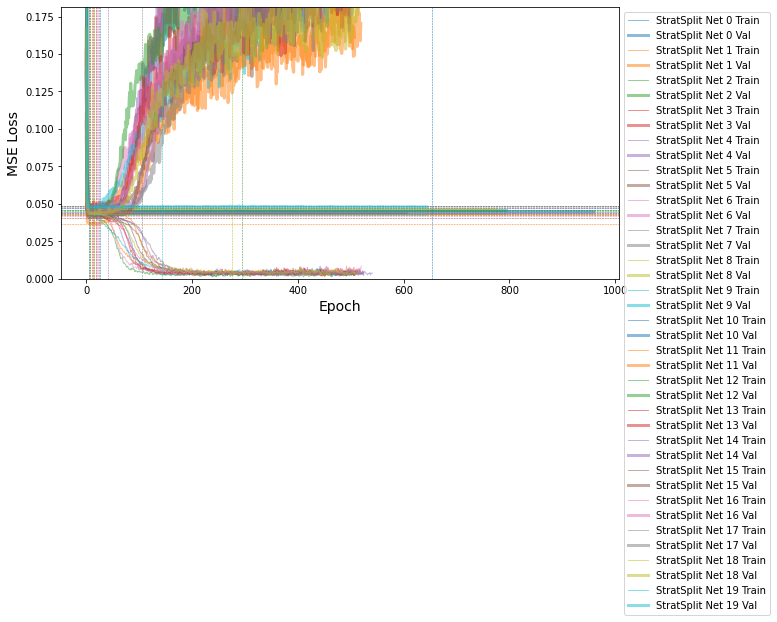

In [93]:
sk_loss_plot(nets)


In [94]:
for n,name in nets:
    _ = view_cls_report(n,Xtrain_strat,ytrain_strat,imods_filt)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [95]:
for n,name in nets:
    _ = view_cls_report(n,Xtest_strat,ytest_strat,imods_filt)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

# wth... just do a hyperparam search anyways...?

# SKORCH search

In [100]:
from sklearn.model_selection import RandomizedSearchCV


In [101]:
net_search = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi,
    #m.DNA_2CNN_Multi,
    #m.DNA_CNN_Multi,
    criterion=torch.nn.BCEWithLogitsLoss(),
    module__seq_len=300,
    module__n_tasks=ytrain.shape[1],
    max_epochs=2000,
    #lr=0.001,
    device=DEVICE,
    callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    verbose=0,

)


In [102]:
params = {
    'lr': [0.01, 0.001, 0.0001,],#loguniform(0.0001, 0.01)
    
    'module__num_filters1': [16,32,64,128],
    'module__num_filters2': [16,32,64,128],
    'module__kernel_size1': [4,8,16,32],
    'module__kernel_size2': [4,8,16,32],
    'module__conv_pool_size1': [2,4,8,16],
    'module__fc_node_num1': [10,50,100,500],
    'module__fc_node_num2': [10,50,100,500],
    'module__dropout1': [0.0,0.2,0.4],
    'module__dropout2': [0.0,0.2,0.4],
    'optimizer':[torch.optim.SGD, torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
}

In [109]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=500, 
    #scoring='neg_mean_squared_error', 
    scoring=['precision','recall','f1_macro'], 
    refit='f1_macro',
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=7,
    verbose=1
)

In [111]:
search.fit(Xtrain_strat,y=ytrain_strat)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1232 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   10.8s finished


ValueError: Stratified CV requires explicitly passing a suitable y.

In [106]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

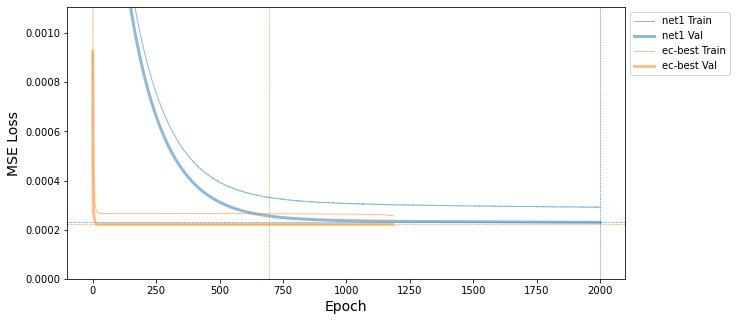

In [28]:
nets = [
    (net_regr1,"net1"),
    (search.best_estimator_,'ec-best')
]

sk_loss_plot(nets)

### inspect hyperparam search results

In [29]:
search.best_estimator_

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 16), stride=(1, 16), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.4, inplace=False)
      (4): Conv2d(16, 128, kernel_size=(1, 16), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.4, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=384, out_features=50, bias=True)
      (9): ReLU()
      (10): Linear(in_features=50, out_features=500, bias=True)
      (11): ReLU()
      (12): Linear(in_features=500, out_features=92, bias=True)
    )
  ),
)

In [30]:
search.best_params_

{'optimizer': torch.optim.adamw.AdamW,
 'module__num_filters2': 128,
 'module__num_filters1': 16,
 'module__kernel_size2': 16,
 'module__kernel_size1': 8,
 'module__fc_node_num2': 500,
 'module__fc_node_num1': 50,
 'module__dropout2': 0.4,
 'module__dropout1': 0.4,
 'module__conv_pool_size1': 16,
 'lr': 0.0001}

In [31]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       71.967057     12.216083         0.021500        0.001165   
1      163.493714      9.668032         0.018877        0.001166   
2       41.803676      1.812703         0.021897        0.002649   
3        0.007967      0.000205         0.000000        0.000000   
4       67.520009     29.807880         0.017562        0.000624   
..            ...           ...              ...             ...   
95      46.600638     20.220994         0.017378        0.000783   
96      74.883984     12.679929         0.018746        0.001701   
97     123.845607     46.760401         0.020805        0.000315   
98     178.359135      2.837735         0.022018        0.003054   
99     171.337422     11.850608         0.015194        0.003347   

                          param_optimizer param_module__num_filters2  \
0   <class 'torch.optim.rmsprop.RMSprop'>                        128   
1           <class 'torch.optim.sgd.SGD'>                         32   
2         <class 'torch.optim.adam.Adam'>                         64   
3       <class 'torch.optim.adamw.AdamW'>                         32   
4   <class 'torch.optim.rmsprop.RMSprop'>                         16   
..                                    ...                        ...   
95  <class 'torch.optim.rmsprop.RMSprop'>                         16   
96      <class 'torch.optim.adamw.AdamW'>                        128   
97      <class 'torch.optim.adamw.AdamW'>                        128   
98          <class 'torch.optim.sgd.SGD'>                        128   
99          <class 'torch.optim.sgd.SGD'>                         32   

   param_module__num_filters1 param_module__kernel_size2  \
0                          64                         16   
1                          16                         32   
2                          32                          4   
3                         128                         32   
4                          32                         32   
..                        ...                        ...   
95                         16                          8   
96                         64                          8   
97                         16                         16   
98                        128                          8   
99                         32                          4   

   param_module__kernel_size1 param_module__fc_node_num2  ...  \
0                           4                         10  ...   
1                           4                         50  ...   
2                          16                         10  ...   
3                           8                        100  ...   
4                           4                         10  ...   
..                        ...                        ...  ...   
95                         32                         50  ...   
96                         16                         10  ...   
97                         16                         10  ...   
98                         16                         10  ...   
99                          8                         10  ...   

   param_module__conv_pool_size1 param_lr  \
0                             16     0.01   
1                              2   0.0001   
2                             16     0.01   
3                             16     0.01   
4                              4    0.001   
..                           ...      ...   
95                             4     0.01   
96                             8   0.0001   
97                             8   0.0001   
98                            16   0.0001   
99                             2    0.001   

                                               params split0_test_score  \
0   {'optimizer': <class 'torch.optim.rmsprop.RMSp...         -0.000296   
1   {'optimizer': <class 'torch.optim.sgd.SGD'>, '...         -0.006479   
2   {'optimizer': <class 'torch.optim.adam.Adam'>,... 

In [32]:
sm_res_df = res_df[[
    "rank_test_score",
    "mean_test_score",
    "param_module__num_filters1",
    "param_module__num_filters2",
    "param_module__kernel_size1",
    "param_module__kernel_size2",
    "param_lr",
    "param_module__fc_node_num1",
    "param_module__fc_node_num2",
    "opt_name"]]

In [33]:
sm_res_df

rank_test_score  mean_test_score param_module__num_filters1  \
0                72        -0.000318                         64   
1                92        -0.006790                         16   
2                16        -0.000260                         32   
3               100              NaN                        128   
4                23        -0.000262                         32   
..              ...              ...                        ...   
95               63        -0.000317                         16   
96               78        -0.000361                         64   
97               42        -0.000270                         16   
98               96        -0.034478                        128   
99               93        -0.017310                         32   

   param_module__num_filters2 param_module__kernel_size1  \
0                         128                          4   
1                          32                          4   
2                          64                         16   
3                          32                          8   
4                          16                          4   
..                        ...                        ...   
95                         16                         32   
96                        128                         16   
97                        128                         16   
98                        128                         16   
99                         32                          8   

   param_module__kernel_size2 param_lr param_module__fc_node_num1  \
0                          16     0.01                        500   
1                          32   0.0001                        100   
2                           4     0.01                         10   
3                          32     0.01                        100   
4                          32    0.001                         50   
..                        ...      ...                        ...   
95                          8     0.01                         50   
96                          8   0.0001                         50   
97                         16   0.0001                        500   
98                          8   0.0001                         50   
99                          4    0.001                         50   

   param_module__fc_node_num2 opt_name  
0                          10  RMSprop  
1                          50      SGD  
2                          10     Adam  
3                         100    AdamW  
4                          10  RMSprop  
..                        ...      ...  
95                         50  RMSprop  
96                         10    AdamW  
97                         10    AdamW  
98                         10      SGD  
99                         10      SGD  

[100 rows x 10 columns]

In [34]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    #shape="param_module__kernel_size1:N"
    
).interactive()

alt.Chart(...)

In [35]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__kernel_size1:O',title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='param_module__num_filters1:N',
#     detail='model_desc:N',
    shape="opt_name:N",
    tooltip=["rank_test_score:O","param_module__num_filters1:N","param_module__kernel_size1:N","param_lr:N","param_module__fc_node_num1:N"]
    
).interactive()

alt.Chart(...)

In [37]:
alt.Chart(sm_res_df).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [38]:
alt.Chart(sm_res_df[~sm_res_df['opt_name'].isin(['SGD'])]).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [39]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__kernel_size1:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [41]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__fc_node_num1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__fc_node_num2:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [42]:
res_df.to_csv('ec_iMod_out/hyper100_1.tsv',sep='\t',index=False)

## Retry with older arch without multiple fc layers

In [16]:
net_search = NeuralNetRegressor(
    #m.DNA_2CNN_2FC_Multi,
    m.DNA_2CNN_Multi,
    #m.DNA_CNN_Multi,
    module__seq_len=300,
    module__n_tasks=y.shape[1],
    max_epochs=2000,
    #lr=0.001,
    device=DEVICE,
    callbacks=[
         EarlyStopping(patience=500),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    verbose=0,

)

In [17]:
params = {
    'lr': [0.01, 0.001, 0.0001,],#loguniform(0.0001, 0.01)
    
    'module__num_filters1': [16,32,64,128],
    'module__num_filters2': [16,32,64,128],
    'module__kernel_size1': [4,8,16,32],
    'module__kernel_size2': [4,8,16,32],
    'module__conv_pool_size1': [2,4,8,16],
    'module__fc_node_num1': [10,50,100,500],
    #'module__fc_node_num2': [10,50,100,500],
    'module__dropout1': [0.0,0.2,0.4],
    'module__dropout2': [0.0,0.2,0.4],
    'optimizer':[torch.optim.SGD, torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
}

In [18]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=100, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=7,
    verbose=1
)

In [19]:
search.fit(Xfull_train,yfull_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 91.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 122.1min finished


RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class 'models.DNA_2CNN_Multi'>,
  module__n_tasks=92,
  module__seq_len=300,
),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'lr': [0.01, 0.001, 0.0001],
                                        'module__conv_pool_size1': [2, 4, 8,
                                                                    16],
                                        'module__dropout1': [0.0, 0.2, 0.4],
                                        'module__dropout2': [0.0, 0.2, 0.4],
                                        'module...
                                                                 500],
                                        'module__kernel_size1': [4, 8, 16, 32],
                                        'module__kernel_size2': [4, 8, 16, 32],
                                        'module__num_filters1': [16, 32, 64,
                    

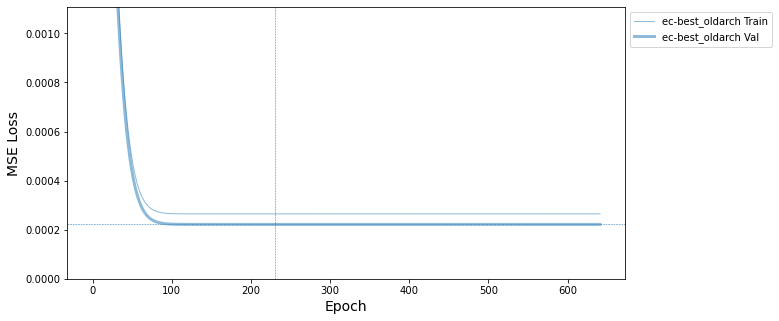

In [20]:
nets = [
    (search.best_estimator_,'ec-best_oldarch')
]

sk_loss_plot(nets)

In [21]:
search.best_params_

{'optimizer': torch.optim.adam.Adam,
 'module__num_filters2': 128,
 'module__num_filters1': 128,
 'module__kernel_size2': 16,
 'module__kernel_size1': 4,
 'module__fc_node_num1': 500,
 'module__dropout2': 0.4,
 'module__dropout1': 0.0,
 'module__conv_pool_size1': 4,
 'lr': 0.01}

In [22]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       69.854427      1.431914         0.020253        0.002287   
1      116.072528      8.235395         0.017485        0.002049   
2       30.852906      5.040905         0.015583        0.000968   
3       52.986956      4.351898         0.021289        0.002168   
4       46.948207      1.685851         0.019074        0.000857   
..            ...           ...              ...             ...   
95      87.054811      7.078445         0.021393        0.000193   
96      51.073176      3.056556         0.018012        0.002369   
97      95.923561      0.919165         0.015507        0.000163   
98      91.409367      0.486924         0.012548        0.002419   
99      60.620135      7.590043         0.013675        0.002894   

                          param_optimizer param_module__num_filters2  \
0   <class 'torch.optim.rmsprop.RMSprop'>                        128   
1           <class 'torch.optim.sgd.SGD'>                         32   
2         <class 'torch.optim.adam.Adam'>                         64   
3       <class 'torch.optim.adamw.AdamW'>                         32   
4   <class 'torch.optim.rmsprop.RMSprop'>                         16   
..                                    ...                        ...   
95      <class 'torch.optim.adamw.AdamW'>                         64   
96  <class 'torch.optim.rmsprop.RMSprop'>                        128   
97          <class 'torch.optim.sgd.SGD'>                         16   
98          <class 'torch.optim.sgd.SGD'>                        128   
99        <class 'torch.optim.adam.Adam'>                        128   

   param_module__num_filters1 param_module__kernel_size2  \
0                          64                         16   
1                          16                         32   
2                          32                          4   
3                         128                         32   
4                          16                          8   
..                        ...                        ...   
95                        128                         16   
96                         64                          4   
97                         32                          4   
98                         16                          4   
99                         32                          8   

   param_module__kernel_size1 param_module__fc_node_num1  ...  \
0                           4                         10  ...   
1                           4                         50  ...   
2                          16                         10  ...   
3                           8                        100  ...   
4                          16                         50  ...   
..                        ...                        ...  ...   
95                         32                         50  ...   
96                          4                         10  ...   
97                         32                         10  ...   
98                         16                        100  ...   
99                          8                         10  ...   

   param_module__conv_pool_size1 param_lr  \
0                              4     0.01   
1                              4    0.001   
2                              4     0.01   
3                              2     0.01   
4                              8    0.001   
..                           ...      ...   
95                             8   0.0001   
96                             4    0.001   
97                             4   0.0001   
98                             8     0.01   
99                            16   0.0001   

                                               params split0_test_score  \
0   {'optimizer': <class 'torch.optim.rmsprop.RMSp...         -0.000296   
1   {'optimizer': <class 'torch.optim.sgd.SGD'>, '...         -0.002919   
2   {'optimizer': <class 'torch.optim.adam.Adam'>,... 

In [24]:
sm_res_df = res_df[[
    "rank_test_score",
    "mean_test_score",
    "param_module__num_filters1",
    "param_module__num_filters2",
    "param_module__kernel_size1",
    "param_module__kernel_size2",
    "param_lr",
    "param_module__fc_node_num1",
    #"param_module__fc_node_num2",
    "opt_name"]]

sm_res_df

rank_test_score  mean_test_score param_module__num_filters1  \
0                68        -0.000318                         64   
1                86        -0.002781                         16   
2                12        -0.000258                         32   
3                 6        -0.000258                        128   
4                38        -0.000274                         16   
..              ...              ...                        ...   
95               26        -0.000262                        128   
96               21        -0.000260                         64   
97               91        -0.028333                         32   
98               57        -0.000313                         16   
99               34        -0.000268                         32   

   param_module__num_filters2 param_module__kernel_size1  \
0                         128                          4   
1                          32                          4   
2                          64                         16   
3                          32                          8   
4                          16                         16   
..                        ...                        ...   
95                         64                         32   
96                        128                          4   
97                         16                         32   
98                        128                         16   
99                        128                          8   

   param_module__kernel_size2 param_lr param_module__fc_node_num1 opt_name  
0                          16     0.01                         10  RMSprop  
1                          32    0.001                         50      SGD  
2                           4     0.01                         10     Adam  
3                          32     0.01                        100    AdamW  
4                           8    0.001                         50  RMSprop  
..                        ...      ...                        ...      ...  
95                         16   0.0001                         50    AdamW  
96                          4    0.001                         10  RMSprop  
97                          4   0.0001                         10      SGD  
98                          4     0.01                        100      SGD  
99                          8   0.0001                         10     Adam  

[100 rows x 9 columns]

In [27]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size1:N"
    
).interactive()

alt.Chart(...)

In [32]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__fc_node_num1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__num_filters1:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [33]:
res_df.to_csv('ec_iMod_out/hyper100_2.tsv',sep='\t',index=False)

## compare against each other?

In [23]:
res_df1 = pd.read_csv('ec_iMod_out/hyper100_1.tsv',sep='\t')
res_df1['run'] = 1

res_df2 = pd.read_csv('ec_iMod_out/hyper100_2.tsv',sep='\t')
res_df2['run']=2

In [28]:
comb_df = pd.concat([res_df1,res_df2])
comb_df = comb_df[[
    "rank_test_score",
    "mean_test_score",
    "param_module__num_filters1",
    "param_module__num_filters2",
    "param_module__kernel_size1",
    "param_module__kernel_size2",
    "param_lr",
    "param_module__fc_node_num1",
    #"param_module__fc_node_num2",
    "opt_name", "run"]]

In [29]:
comb_df

rank_test_score  mean_test_score  param_module__num_filters1  \
0                72        -0.000318                          64   
1                92        -0.006790                          16   
2                16        -0.000260                          32   
3               100              NaN                         128   
4                23        -0.000262                          32   
..              ...              ...                         ...   
95               26        -0.000262                         128   
96               21        -0.000260                          64   
97               91        -0.028333                          32   
98               57        -0.000313                          16   
99               34        -0.000268                          32   

    param_module__num_filters2  param_module__kernel_size1  \
0                          128                           4   
1                           32                           4   
2                           64                          16   
3                           32                           8   
4                           16                           4   
..                         ...                         ...   
95                          64                          32   
96                         128                           4   
97                          16                          32   
98                         128                          16   
99                         128                           8   

    param_module__kernel_size2  param_lr  param_module__fc_node_num1 opt_name  \
0                           16    0.0100                         500  RMSprop   
1                           32    0.0001                         100      SGD   
2                            4    0.0100                          10     Adam   
3                           32    0.0100                         100    AdamW   
4                           32    0.0010                          50  RMSprop   
..                         ...       ...                         ...      ...   
95                          16    0.0001                          50    AdamW   
96                           4    0.0010                          10  RMSprop   
97                           4    0.0001                          10      SGD   
98                           4    0.0100                         100      SGD   
99                           8    0.0001                          10     Adam   

    run  
0     1  
1     1  
2     1  
3     1  
4     1  
..  ...  
95    2  
96    2  
97    2  
98    2  
99    2  

[200 rows x 10 columns]

In [30]:
alt.Chart(comb_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='run:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [31]:
alt.Chart(comb_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__kernel_size1:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

## try cros_val_predict

In [ ]:
# {'optimizer': torch.optim.adam.Adam,
#  'module__num_filters2': 128,
#  'module__num_filters1': 128,
#  'module__kernel_size2': 16,
#  'module__kernel_size1': 4,
#  'module__fc_node_num1': 500,
#  'module__dropout2': 0.4,
#  'module__dropout1': 0.0,
#  'module__conv_pool_size1': 4,
#  'lr': 0.01}

In [55]:
net_regr_man = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=4,
    module__kernel_size2=16,
    module__conv_pool_size1=4, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 500,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.01,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [56]:
from sklearn.model_selection import cross_val_predict

In [57]:
y_pred = cross_val_predict(net_regr_man, X, y, cv=5)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      786.0800        0.0009     +  0.1267
      2        0.0008        0.0008     +  0.1091
      3        0.0005        0.0003     +  0.1041
      4        0.0003        0.0003     +  0.0953
      5        0.0003        0.0003     +  0.0880
      6        0.0003        0.0003     +  0.0831
      7        0.0003        0.0003     +  0.0831
      8        0.0003        0.0003     +  0.0817
      9        0.0003        0.0003     +  0.0818
     10        0.0003        0.0003     +  0.0820
     11        0.0003        0.0003        0.0831
     12        0.0003        0.0003        0.0819
     13        0.0003        0.0003        0.0814
     14        0.0003        0.0003        0.0817
     15        0.0003        0.0003        0.0815
     16        0.0003        0.0003     +  0.0816
     17        0.0003        0.0003        0.0820
     18        0.0003        0.0003        0.0814


    160        0.0003        0.0003        0.0813
    161        0.0003        0.0003        0.0819
    162        0.0003        0.0003        0.0814
    163        0.0003        0.0003        0.0813
    164        0.0003        0.0003        0.0812
    165        0.0003        0.0003        0.0816
    166        0.0003        0.0003        0.0816
    167        0.0003        0.0003        0.0816
    168        0.0003        0.0003        0.0816
    169        0.0003        0.0003        0.0816
    170        0.0003        0.0003        0.0815
    171        0.0003        0.0003        0.0816
    172        0.0003        0.0003        0.0816
    173        0.0003        0.0003        0.0818
    174        0.0003        0.0003        0.0815
    175        0.0003        0.0003        0.0812
    176        0.0003        0.0003        0.0811
    177        0.0003        0.0003        0.0814
    178        0.0003        0.0003        0.0817
    179        0.0003        0.0003        0.0816


    324        0.0003        0.0003        0.0814
    325        0.0003        0.0003        0.0813
    326        0.0003        0.0003        0.0816
    327        0.0003        0.0003        0.0814
    328        0.0003        0.0003        0.0814
    329        0.0003        0.0003        0.0815
    330        0.0003        0.0003        0.0814
    331        0.0003        0.0003        0.0818
    332        0.0003        0.0003        0.0817
    333        0.0003        0.0003        0.0814
    334        0.0003        0.0003        0.0813
    335        0.0003        0.0003        0.0816
    336        0.0003        0.0003        0.0812
    337        0.0003        0.0003        0.0820
    338        0.0003        0.0003        0.0818
    339        0.0003        0.0003        0.0815
    340        0.0003        0.0003        0.0815
    341        0.0003        0.0003        0.0817
    342        0.0003        0.0003        0.0822
    343        0.0003        0.0003        0.0817


    488        0.0003        0.0003        0.0821
    489        0.0003        0.0003        0.0825
    490        0.0003        0.0003        0.0824
    491        0.0003        0.0003        0.0837
    492        0.0003        0.0003        0.0821
    493        0.0003        0.0003        0.0818
    494        0.0003        0.0003        0.0820
    495        0.0003        0.0003        0.0819
    496        0.0003        0.0003        0.0816
    497        0.0003        0.0003        0.0819
    498        0.0003        0.0003        0.0815
    499        0.0003        0.0003        0.0813
    500        0.0003        0.0003        0.0815
    501        0.0003        0.0003        0.0814
    502        0.0003        0.0003        0.0814
    503        0.0003        0.0003        0.0815
    504        0.0003        0.0003        0.0823
    505        0.0003        0.0003        0.0821
    506        0.0003        0.0003        0.0817
    507        0.0003        0.0003        0.0818


    130        0.0003        0.0002        0.0815
    131        0.0003        0.0002        0.0817
    132        0.0003        0.0002        0.0813
    133        0.0003        0.0002        0.0812
    134        0.0003        0.0002        0.0816
    135        0.0003        0.0002        0.0818
    136        0.0003        0.0002        0.0814
    137        0.0003        0.0002        0.0813
    138        0.0003        0.0002        0.0814
    139        0.0003        0.0002        0.0816
    140        0.0003        0.0002        0.0817
    141        0.0003        0.0002        0.0820
    142        0.0003        0.0002        0.0822
    143        0.0003        0.0002        0.0819
    144        0.0003        0.0002        0.0822
    145        0.0003        0.0002        0.0820
    146        0.0003        0.0002        0.0820
    147        0.0003        0.0002        0.0821
    148        0.0003        0.0002        0.0820
    149        0.0003        0.0002        0.0820


    294        0.0003        0.0002        0.0817
    295        0.0003        0.0002        0.0815
    296        0.0003        0.0002        0.0818
    297        0.0003        0.0002        0.0820
    298        0.0003        0.0002        0.0818
    299        0.0003        0.0002        0.0815
    300        0.0003        0.0002        0.0817
    301        0.0003        0.0002        0.0813
    302        0.0003        0.0002        0.0815
    303        0.0003        0.0002        0.0817
    304        0.0003        0.0002        0.0813
    305        0.0003        0.0002        0.0817
    306        0.0003        0.0002        0.0814
    307        0.0003        0.0002        0.0815
    308        0.0003        0.0002        0.0816
    309        0.0003        0.0002        0.0815
    310        0.0003        0.0002        0.0816
    311        0.0003        0.0002        0.0816
    312        0.0003        0.0002        0.0819
    313        0.0003        0.0002        0.0819


    458        0.0003        0.0002        0.0817
    459        0.0003        0.0002        0.0819
    460        0.0003        0.0002        0.0819
    461        0.0003        0.0002        0.0817
    462        0.0003        0.0002        0.0818
    463        0.0003        0.0002        0.0819
    464        0.0003        0.0002        0.0820
    465        0.0003        0.0002        0.0818
    466        0.0003        0.0002        0.0817
    467        0.0003        0.0002        0.0821
    468        0.0003        0.0002        0.0817
    469        0.0003        0.0002        0.0816
    470        0.0003        0.0002        0.0819
    471        0.0003        0.0002        0.0820
    472        0.0003        0.0002        0.0816
    473        0.0003        0.0002        0.0816
    474        0.0003        0.0002        0.0816
    475        0.0003        0.0002        0.0815
    476        0.0003        0.0002        0.0815
    477        0.0003        0.0002        0.0821


    108        0.0003        0.0002        0.0815
    109        0.0003        0.0002        0.0820
    110        0.0003        0.0002        0.0821
    111        0.0003        0.0002        0.0817
    112        0.0003        0.0002        0.0819
    113        0.0003        0.0002        0.0819
    114        0.0003        0.0002        0.0815
    115        0.0003        0.0002        0.0817
    116        0.0003        0.0002        0.0819
    117        0.0003        0.0002        0.0815
    118        0.0003        0.0002        0.0816
    119        0.0003        0.0002        0.0818
    120        0.0003        0.0002        0.0816
    121        0.0003        0.0002        0.0815
    122        0.0003        0.0002        0.0820
    123        0.0003        0.0002        0.0817
    124        0.0003        0.0002        0.0814
    125        0.0003        0.0002        0.0818
    126        0.0003        0.0002        0.0817
    127        0.0003        0.0002        0.0814


    272        0.0003        0.0002        0.0818
    273        0.0003        0.0002        0.0816
    274        0.0003        0.0002        0.0815
    275        0.0003        0.0002        0.0815
    276        0.0003        0.0002        0.0818
    277        0.0003        0.0002        0.0815
    278        0.0003        0.0002        0.0815
    279        0.0003        0.0002        0.0819
    280        0.0003        0.0002        0.0816
    281        0.0003        0.0002        0.0813
    282        0.0003        0.0002        0.0816
    283        0.0003        0.0002        0.0817
    284        0.0003        0.0002        0.0814
    285        0.0003        0.0002        0.0815
    286        0.0003        0.0002        0.0818
    287        0.0003        0.0002        0.0813
    288        0.0003        0.0002        0.0815
    289        0.0003        0.0002        0.0813
    290        0.0003        0.0002        0.0816
    291        0.0003        0.0002        0.0815


    436        0.0003        0.0002        0.0820
    437        0.0003        0.0002        0.0817
    438        0.0003        0.0002        0.0817
    439        0.0003        0.0002        0.0816
    440        0.0003        0.0002        0.0816
    441        0.0003        0.0002        0.0817
    442        0.0003        0.0002        0.0818
    443        0.0003        0.0002        0.0820
    444        0.0003        0.0002        0.0819
    445        0.0003        0.0002        0.0820
    446        0.0003        0.0002        0.0821
    447        0.0003        0.0002        0.0824
    448        0.0003        0.0002        0.0824
    449        0.0003        0.0002        0.0824
    450        0.0003        0.0002        0.0824
    451        0.0003        0.0002        0.0824
    452        0.0003        0.0002        0.0820
    453        0.0003        0.0002        0.0823
    454        0.0003        0.0002        0.0820
    455        0.0003        0.0002        0.0820


     85        0.0003        0.0002        0.0823
     86        0.0003        0.0002        0.0823
     87        0.0003        0.0002        0.0827
     88        0.0003        0.0002        0.0822
     89        0.0003        0.0002        0.0819
     90        0.0003        0.0002        0.0820
     91        0.0003        0.0002        0.0821
     92        0.0003        0.0002        0.0820
     93        0.0003        0.0002        0.0824
     94        0.0003        0.0002        0.0822
     95        0.0003        0.0002        0.0828
     96        0.0003        0.0002        0.0825
     97        0.0003        0.0002        0.0816
     98        0.0003        0.0002        0.0823
     99        0.0003        0.0002        0.0824
    100        0.0003        0.0002        0.0822
    101        0.0003        0.0002        0.0826
    102        0.0003        0.0002        0.0819
    103        0.0003        0.0002        0.0816
    104        0.0003        0.0002        0.0816


    249        0.0003        0.0002        0.0818
    250        0.0003        0.0002        0.0821
    251        0.0003        0.0002        0.0822
    252        0.0003        0.0002        0.0818
    253        0.0003        0.0002        0.0825
    254        0.0003        0.0002        0.0818
    255        0.0003        0.0002        0.0817
    256        0.0003        0.0002        0.0818
    257        0.0003        0.0002        0.0817
    258        0.0003        0.0002        0.0820
    259        0.0003        0.0002        0.0824
    260        0.0003        0.0002        0.0823
    261        0.0003        0.0002        0.0817
    262        0.0003        0.0002        0.0823
    263        0.0003        0.0002        0.0818
    264        0.0003        0.0002        0.0817
    265        0.0003        0.0002        0.0818
    266        0.0003        0.0002        0.0816
    267        0.0003        0.0002        0.0814
    268        0.0003        0.0002        0.0819


    413        0.0003        0.0002        0.0828
    414        0.0003        0.0002        0.0833
    415        0.0003        0.0002        0.0831
    416        0.0003        0.0002        0.0824
    417        0.0003        0.0002        0.0827
    418        0.0003        0.0002        0.0827
    419        0.0003        0.0002        0.0821
    420        0.0003        0.0002        0.0819
    421        0.0003        0.0002        0.0823
    422        0.0003        0.0002        0.0826
    423        0.0003        0.0002        0.0824
    424        0.0003        0.0002        0.0824
    425        0.0003        0.0002        0.0826
    426        0.0003        0.0002        0.0834
    427        0.0003        0.0002        0.0833
    428        0.0003        0.0002        0.0830
    429        0.0003        0.0002        0.0824
    430        0.0003        0.0002        0.0823
    431        0.0003        0.0002        0.0827
    432        0.0003        0.0002        0.0825


     61        0.0003        0.0002        0.0828
     62        0.0003        0.0002        0.0828
     63        0.0003        0.0002        0.0823
     64        0.0003        0.0002        0.0830
     65        0.0003        0.0002        0.0822
     66        0.0003        0.0002        0.0825
     67        0.0003        0.0002        0.0821
     68        0.0003        0.0002        0.0818
     69        0.0003        0.0002        0.0821
     70        0.0003        0.0002        0.0821
     71        0.0003        0.0002        0.0825
     72        0.0003        0.0002        0.0824
     73        0.0003        0.0002        0.0822
     74        0.0003        0.0002        0.0824
     75        0.0003        0.0002        0.0825
     76        0.0003        0.0002        0.0825
     77        0.0003        0.0002        0.0827
     78        0.0003        0.0002        0.0828
     79        0.0003        0.0002        0.0826
     80        0.0003        0.0002        0.0821


    225        0.0003        0.0002        0.0824
    226        0.0003        0.0002        0.0825
    227        0.0003        0.0002        0.0825
    228        0.0003        0.0002        0.0825
    229        0.0003        0.0002        0.0819
    230        0.0003        0.0002        0.0823
    231        0.0003        0.0002        0.0828
    232        0.0003        0.0002        0.0827
    233        0.0003        0.0003        0.0829
    234        0.0003        0.0002        0.0829
    235        0.0003        0.0002        0.0828
    236        0.0003        0.0002        0.0819
    237        0.0003        0.0002        0.0830
    238        0.0003        0.0002        0.0825
    239        0.0003        0.0002        0.0825
    240        0.0003        0.0002        0.0827
    241        0.0003        0.0002        0.0819
    242        0.0003        0.0002        0.0823
    243        0.0003        0.0002        0.0824
    244        0.0003        0.0002        0.0818


    389        0.0003        0.0002        0.0826
    390        0.0003        0.0002        0.0824
    391        0.0003        0.0002        0.0833
    392        0.0003        0.0002        0.0829
    393        0.0003        0.0002        0.0835
    394        0.0003        0.0002        0.0837
    395        0.0003        0.0002        0.0834
    396        0.0003        0.0002        0.0832
    397        0.0003        0.0002        0.0832
    398        0.0003        0.0002        0.0833
    399        0.0003        0.0002        0.0828
    400        0.0003        0.0002        0.0835
    401        0.0003        0.0002        0.0835
    402        0.0003        0.0002        0.0835
    403        0.0003        0.0002        0.0830
    404        0.0003        0.0002        0.0830
    405        0.0003        0.0002        0.0832
    406        0.0003        0.0002        0.0838
    407        0.0003        0.0002        0.0828
    408        0.0003        0.0002        0.0832


TypeError: 'NoneType' object is not subscriptable

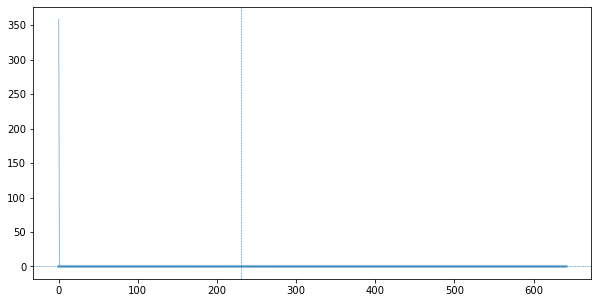

In [59]:
nets = [
    (search.best_estimator_,'ec-best_oldarch'),
    (net_regr_man, 'manual cvp?')
]

sk_loss_plot(nets)

YTRUE torch.Size([1362, 92])
**** ave r2:     -0.0005887257365900982
**** r2 overall: -0.0005887258745234803
YTRUE torch.Size([341, 92])
**** ave r2:     -0.0030626685740936716
**** r2 overall: -0.003062669608321528


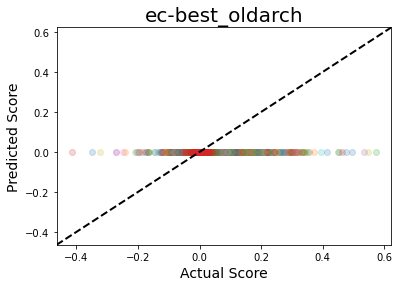

NotInitializedError: This NeuralNetRegressor instance is not initialized yet. Call 'initialize' or 'fit' with appropriate arguments before using this method.

In [60]:
view_preds(nets,make_legend=False)

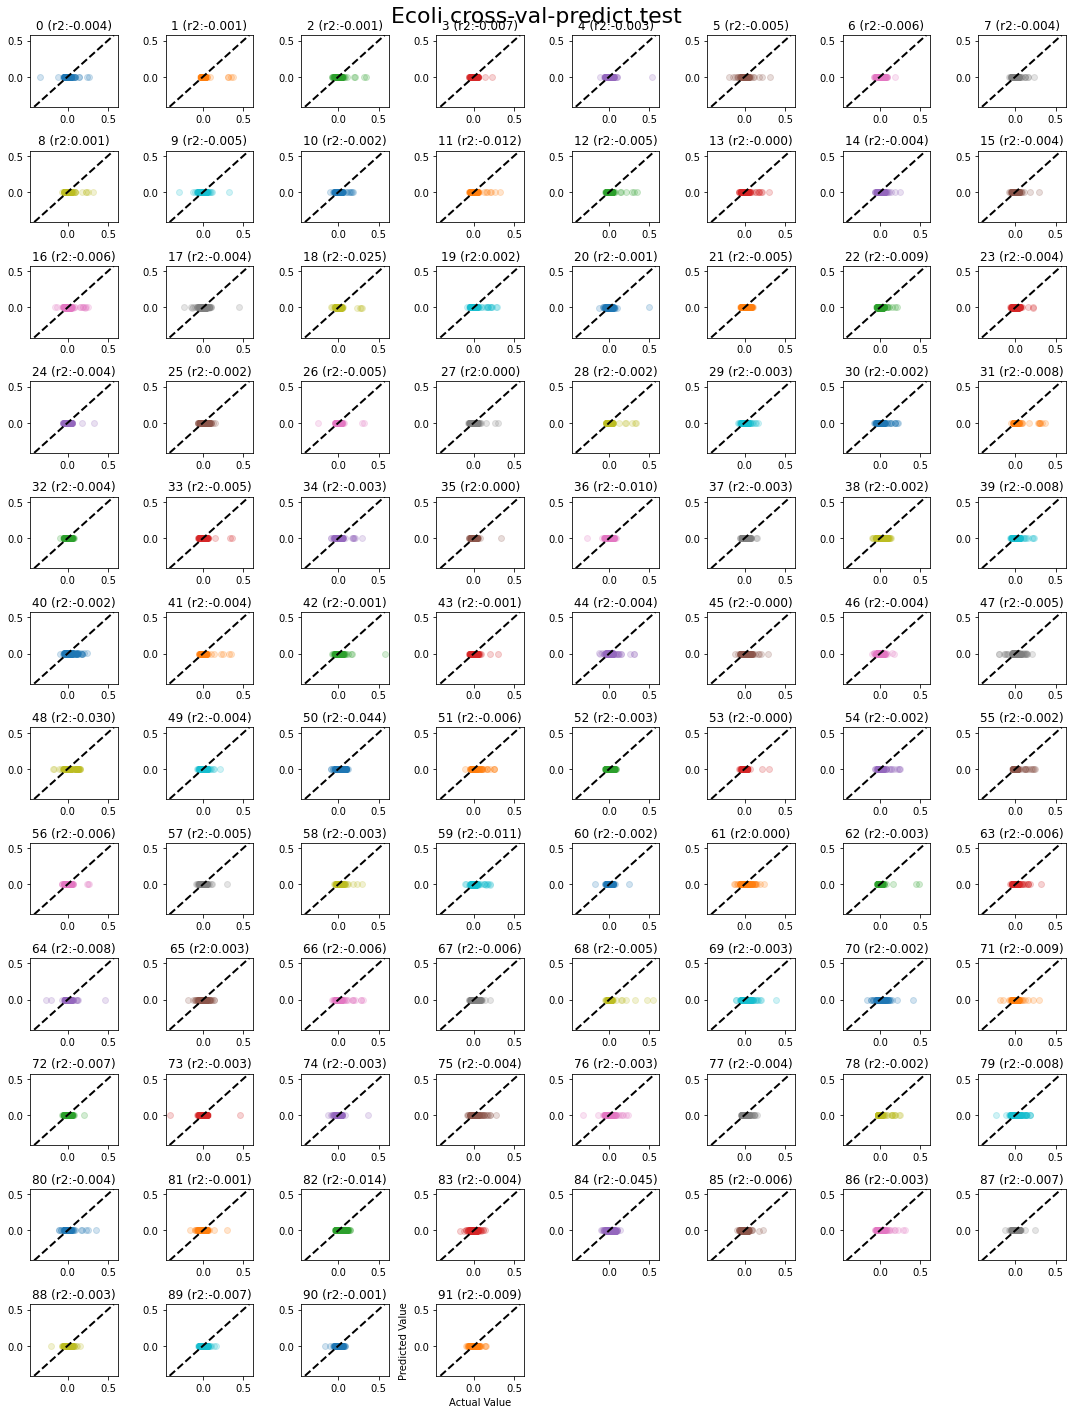

In [61]:
view_multi_parity("Ecoli cross-val-predict test", 
    y, 
    y_pred,
    rigid=True)

# Next ideas
* Retry with data aug 
* gradient clipping


# NOTE: 
--> using "load_best" = True seems to work now?? Stops on the final one